----------------------------------------------------------------
##                                                         EXAMEN MACHINE LEARNING
------------------------------------------------

In [3]:
from imblearn.over_sampling import SMOTE


## Contexte

L'entreprise "Prêt à dépenser" est une société financière spécialisée dans l’octroi de crédits à la consommation. Elle cible principalement des clients ayant peu ou pas d’historique de crédit, rendant l’évaluation du risque plus complexe.

Afin d’améliorer son processus de décision et d’optimiser la gestion des risques, l’entreprise souhaite développer un outil de scoring crédit basé sur un algorithme de classification. Cet outil devra estimer la probabilité qu’un client rembourse son prêt et classer automatiquement les demandes en "crédit accordé" ou "crédit refusé".

## Objectif
L’objectif de ce projet est de concevoir et d’évaluer un modèle de machine learning capable de prédire si un client remboursera son crédit. Le modèle exploitera des données variées :

Données socio-économiques (revenu, emploi, niveau d’éducation, etc.)
Données comportementales (historique de dépenses, transactions bancaires, etc.)
Informations provenant d’autres institutions financières

In [ ]:
# Importation des Bibliothéques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Importation des différents fichiers
application_train = pd.read_csv("application_train.csv", sep=",")
application_test = pd.read_csv("application_test.csv", sep=",")
bureau = pd.read_csv("bureau.csv", sep=",")
bureau_balance=pd.read_csv("bureau_balance.csv", sep=",")
installments_payments = pd.read_csv("installments_payments.csv", sep=",")
previous_application = pd.read_csv("previous_application.csv", sep=",")

# CONCATENATION PAR AGREGATION
La concaténation par agrégation est une technique utilisée en traitement de données, en machine learning ou en analyse de données pour combiner des informations provenant de plusieurs sources ou de plusieurs variables en un seul ensemble de données structuré. Dans notre cas nous allons utiliser l'agrégation par la moyenne qui est une méthode simple et efficace pour résumer des données numériques. Cette derniere est particulièrement utile pour créer des caractéristiques en machine learning, simplifier l'analyse de données ou réduire la dimensionnalité

In [ ]:
# Fonction pour agréger toutes les colonnes numériques par la moyenne
def aggregate_mean(df, group_column, prefix):
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    # Exclure la colonne de regroupement si elle est numérique
    if group_column in numeric_cols:
        numeric_cols.remove(group_column)

    # Agrégation des colonnes numériques par la moyenne
    agg_df = df.groupby(group_column)[numeric_cols].mean().reset_index()

    # Renommer les colonnes agrégées
    agg_df.columns = [group_column] + [f'{prefix}_{col}_MEAN' for col in numeric_cols]

    return agg_df

# Agrégation des fichiers par la moyenne
previous_agg = aggregate_mean(previous_application, 'SK_ID_CURR', 'PREV')
bureau_agg = aggregate_mean(bureau, 'SK_ID_CURR', 'BUREAU')
installments_agg = aggregate_mean(installments_payments, 'SK_ID_CURR', 'INSTALL')

# Fusionner les données agrégées avec application_train
# Conserver uniquement la colonne TARGET de application_train
target = application_train[['SK_ID_CURR', 'TARGET']]  # Isoler la colonne TARGET
train_data = application_train.drop(columns=['TARGET'])  # Supprimer TARGET pour éviter les duplications

# Fusionner les données agrégées
train_data = pd.merge(train_data, previous_agg, on='SK_ID_CURR', how='left')
train_data = pd.merge(train_data, bureau_agg, on='SK_ID_CURR', how='left')
train_data = pd.merge(train_data, installments_agg, on='SK_ID_CURR', how='left')

# Réintégrer la colonne TARGET
train_data = pd.merge(train_data, target, on='SK_ID_CURR', how='left')

# Fusionner les données agrégées avec application_test
test_data = pd.merge(application_test, previous_agg, on='SK_ID_CURR', how='left')
test_data = pd.merge(test_data, bureau_agg, on='SK_ID_CURR', how='left')
test_data = pd.merge(test_data, installments_agg, on='SK_ID_CURR', how='left')

In [ ]:
#Afficher les cinq premieres ligne
print("Train Data après agrégation :")
train_data.head()

Train Data après agrégation :


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002         Cash loans           M            N               Y   
1      100003         Cash loans           F            N               N   
2      100004    Revolving loans           M            Y               Y   
3      100006         Cash loans           F            N               Y   
4      100007         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... BUREAU_DAYS_CREDIT_UPDATE_MEAN BUREAU_AMT_ANNUITY_MEAN  \
0  ...                       -499.875                     0.0   
1  ...                       -816.000                     NaN   
2  ...                       -532.000                     NaN   
3  ...                            NaN                     NaN   
4  ...                       -783.000                     NaN   

  INSTALL_SK_ID_PREV_MEAN INSTALL_NUM_INSTALMENT_VERSION_MEAN  \
0            1.038818e+06                            1.052632   
1            2.290070e+06                            1.040000   
2            1.564014e+06                            1.333333   
3            2.217428e+06                            1.125000   
4            2.048985e+06                            1.166667   

  INSTALL_NUM_INSTALMENT_NUMBER_MEAN  INSTALL_DAYS_INSTALMENT_MEAN  \
0                          10.000000                   -295.000000   
1                           5.080000                  -1378.160000   
2                           2.000000                   -754.000000   
3                           4.437500                   -252.250000   
4                           7.045455                  -1028.606061   

   INSTALL_DAYS_ENTRY_PAYMENT_MEAN  INSTALL_AMT_INSTALMENT_MEAN  \
0                      -315.421053                 11559.247105   
1                     -1385.320000                 64754.586000   
2                      -761.666667                  7096.155000   
3                      -271.625000                 62947.088438   
4                     -1032.242424                 12666.444545   

   INSTALL_AMT_PAYMENT_MEAN  TARGET  
0              11559.247105       1  
1              64754.586000       0  
2               7096.155000       0  
3              62947.088438       0  
4              12214.060227       0  

[5 rows x 162 columns]

In [ ]:
#pip install skimpy
from skimpy import skim

In [ ]:
skim(train_data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 307511 │ │ float64     │ 105   │                                                          │
│ │ Number of columns │ 162    │ │ int32       │ 41    │                                                          │
│ └───────────────────┴────────┘ │ string      │ 16    │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column  ┃ NA     ┃ NA %    ┃ mean    ┃ sd      ┃ p0       ┃ p25     ┃ p50     ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ SK_ID_C │      0 │       0 │  278200 │  102800 │   100000 │  189100 │  278200 │  367100 │  456300 │ ▇▇▇▇▇▇ │  │
│ │ URR     │        │         │         │         │          │         │         │         │         │        │  │
│ │ CNT_CHI │      0 │       0 │  0.4171 │  0.7221 │        0 │       0 │       0 │       1 │      19 │   ▇    │  │
│ │ LDREN   │        │         │         │         │          │         │         │         │         │        │  │
│ │ AMT_INC │      0 │       0 │  168800 │  237100 │    25650 │  112500 │  147200 │  202500 │ 1170000 │   ▇    │  │
│ │ OME_TOT │        │         │         │         │          │         │         │         │      00 │        │  │
│ │ AL      │        │         │         │         │          │         │         │         │         │        │  │
│ │ AMT_CRE │      0 │       0 │  599000 │  402500 │    45000 │  270000 │  513500 │  808600 │ 4050000 │   ▇▃   │  │
│ │ DIT     │        │         │         │         │          │         │         │         │         │        │  │
│ │ AMT_ANN │     12 │ 0.00390 │   27110 │   14490 │     1616 │   16520 │   24900 │   34600 │  258000 │   ▇▁   │  │
│ │ UITY    │        │ 2299429 │         │         │          │         │         │         │         │        │  │
│ │         │        │ 9390914 │         │         │          │         │         │         │         │        │  │
│ │ AMT_GOO │    278 │ 0.09040 │  538400 │  369400 │    40500 │  238500 │  450000 │  679500 │ 4050000 │   ▇▂   │  │
│ │ DS_PRIC │        │ 3270126 │         │         │          │         │         │         │         │        │  │
│ │ E       │        │   92229 │         │         │          │         │         │         │         │        │  │
│ │ REGION_ │      0 │       0 │ 0.02087 │ 0.01383 │  0.00029 │ 0.01001 │ 0.01885 │ 0.02866 │ 0.07251 │ ▇▇▇▁ ▁ │  │
│ │ POPULAT │        │         │         │         │          │         │         │         │         │        │  │
│ │ ION_REL │        │         │         │         │          │         │         │         │         │        │  │
│ │ ATIVE   │        │         │         │         │          │         │         │         │         │        │  │
│ │ DAYS_BI │      0 │       0 │  -16040 │    4364 │   -25230 │  -19680 │  -15750 │  -12410 │   -7489 │ ▃▆▆▇▇▃ │  │
│ │ RTH     │        │         │         │         │          │         │         │         │         │        │  │
│ │ DAYS_EM │      0 │       0 │   63820 │  141300 │   -

On peut noter a travers le tableau ci dessus, que le package skim,nous avons une vision plus affrondis sur la distribution de notre dataset que le fonction describe() de pandas avec seulement une seule ligne de code

- En plus nous avons une idée sur la répartion du dataset en terme de type et en terme de valeurs manquantes

In [ ]:
print("Test Data après agrégation :")
test_data.head()

Test Data après agrégation :


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN BUREAU_DAYS_CREDIT_UPDATE_MEAN  \
0  ...                                0.0                     -93.142857   
1  ...                                0.0                     -54.333333   
2  ...                                0.0                    -775.500000   
3  ...                                0.0                    -651.500000   
4  ...                                NaN                            NaN   

  BUREAU_AMT_ANNUITY_MEAN INSTALL_SK_ID_PREV_MEAN  \
0             3545.357143            1.576389e+06   
1             1420.500000            2.495675e+06   
2                0.000000            1.911853e+06   
3             3012.010714            2.115491e+06   
4                     NaN            2.327930e+06   

  INSTALL_NUM_INSTALMENT_VERSION_MEAN  INSTALL_NUM_INSTALMENT_NUMBER_MEAN  \
0                            1.142857                            2.714286   
1                            1.111111                            5.000000   
2                            0.277419                           43.729032   
3                            0.460177                           30.504425   
4                            1.000000                            6.500000   

   INSTALL_DAYS_INSTALMENT_MEAN  INSTALL_DAYS_ENTRY_PAYMENT_MEAN  \
0                  -2187.714286                     -2195.000000   
1                   -586.000000                      -609.555556   
2                  -1352.929032                     -1358.109677   
3                   -855.548673                      -858.548673   
4                   -622.000000                      -634.250000   

   INSTALL_AMT_INSTALMENT_MEAN  INSTALL_AMT_PAYMENT_MEAN  
0                  5885.132143               5885.132143  
1                  6240.205000               6240.205000  
2                 10897.898516               9740.235774  
3                  4979.282257               4356.731549  
4                 11100.337500              11100.337500  

[5 rows x 161 columns]

# LISTE DES VALEURS MANQUANTES ET ABERRANTES AU NIVEAU DE LA VARIABLE DU Train_data

In [ ]:
# Somme total des valeurs manquantes
train_data.isnull().sum()

SK_ID_CURR                             0
NAME_CONTRACT_TYPE                     0
CODE_GENDER                            0
FLAG_OWN_CAR                           0
FLAG_OWN_REALTY                        0
                                   ...  
INSTALL_DAYS_INSTALMENT_MEAN       15868
INSTALL_DAYS_ENTRY_PAYMENT_MEAN    15876
INSTALL_AMT_INSTALMENT_MEAN        15868
INSTALL_AMT_PAYMENT_MEAN           15876
TARGET                                 0
Length: 162, dtype: int64

In [ ]:
# Verification des valeurs manquantes sur 10 lignes
train_data.isnull().head(10)

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       False               False        False         False            False   
1       False               False        False         False            False   
2       False               False        False         False            False   
3       False               False        False         False            False   
4       False               False        False         False            False   
5       False               False        False         False            False   
6       False               False        False         False            False   
7       False               False        False         False            False   
8       False               False        False         False            False   
9       False               False        False         False            False   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0         False             False       False        False            False   
1         False             False       False        False            False   
2         False             False       False        False            False   
3         False             False       False        False            False   
4         False             False       False        False            False   
5         False             False       False        False            False   
6         False             False       False        False            False   
7         False             False       False        False            False   
8         False             False       False        False            False   
9         False             False       False        False            False   

   ...  BUREAU_DAYS_CREDIT_UPDATE_MEAN  BUREAU_AMT_ANNUITY_MEAN  \
0  ...                           False                    False   
1  ...                           False                     True   
2  ...                           False                     True   
3  ...                            True                     True   
4  ...                           False                     True   
5  ...                           False                     True   
6  ...                           False                     True   
7  ...                           False                     True   
8  ...                           False                     True   
9  ...                            True                     True   

   INSTALL_SK_ID_PREV_MEAN  INSTALL_NUM_INSTALMENT_VERSION_MEAN  \
0                    False                                False   
1                    False                                False   
2                    False                                False   
3                    False                                False   
4                    False                                False   
5                    False                                False   
6                    False                                False   
7                    False                                False   
8                    False                                False   
9                    False                                False   

   INSTALL_NUM_INSTALMENT_NUMBER_MEAN  INSTALL_DAYS_INSTALMENT_MEAN  \
0                               False                         False   
1                               False                         False   
2                               False                         False   
3                               False                         False   
4                               False                         False   
5                               False                         False   
6                               False                         False   
7                               False                         False   
8                               False                         False   
9                               False                  

<Axes: ylabel='count'>

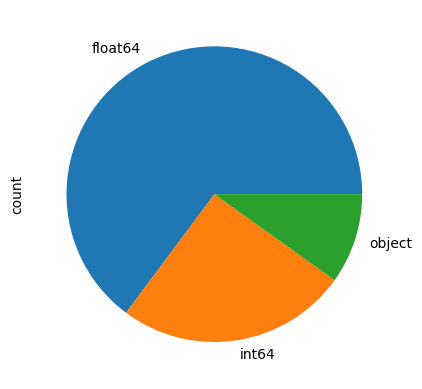

In [ ]:
# Proportion de repartion des données en fonction des differents type
train_data.dtypes.value_counts().plot.pie()

In [ ]:
train_data.select_dtypes("int64")

SK_ID_CURR  CNT_CHILDREN  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_ID_PUBLISH  \
0           100002             0       -9461           -637            -2120   
1           100003             0      -16765          -1188             -291   
2           100004             0      -19046           -225            -2531   
3           100006             0      -19005          -3039            -2437   
4           100007             0      -19932          -3038            -3458   
...            ...           ...         ...            ...              ...   
307506      456251             0       -9327           -236            -1982   
307507      456252             0      -20775         365243            -4090   
307508      456253             0      -14966          -7921            -5150   
307509      456254             0      -11961          -4786             -931   
307510      456255             0      -16856          -1262             -410   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0                0                 1   
307508           1               1                0                 1   
307509           1               1                0                 1   
307510           1               1                1                 1   

        FLAG_PHONE  ...  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
0                1  ...                 0                 0                 0   
1                1  ...                 0                 0                 0   
2                1  ...                 0                 0                 0   
3                0  ...                 0                 0                 0   
4                0  ...                 0                 0                 0   
...            ...  ...               ...               ...               ...   
307506           0  ...                 0                 0                 0   
307507           1  ...                 0                 0                 0   
307508           0  ...                 0                 0                 0   
307509           0  ...                 0                 0                 0   
307510           1  ...                 0                 0                 0   

        FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  \
0                      0                 0                 0   
1                      0                 0                 0   
2                      0                 0                 0   
3                      0                 0                 0   
4                      0                 0                 0   
...                  ...               ...               ...   
307506                 0                 0                 0   
307507                 0                 0                 0   
307508                 0                 0                 0   
307509                 0                 0                 0   
307510                 0                 0                 0   

        FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  TARGET  
0                      0                 0                 0       1  
1                      0                 0                 0       0  
2                      0                 0                 0       0  
3                      0                 0                 0       0  
4                      0                 0                 0       0  
..

In [ ]:
train_data.select_dtypes("float64")

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               202500.0    406597.5      24700.5         351000.0   
1               270000.0   1293502.5      35698.5        1129500.0   
2                67500.0    135000.0       6750.0         135000.0   
3               135000.0    312682.5      29686.5         297000.0   
4               121500.0    513000.0      21865.5         513000.0   
...                  ...         ...          ...              ...   
307506          157500.0    254700.0      27558.0         225000.0   
307507           72000.0    269550.0      12001.5         225000.0   
307508          153000.0    677664.0      29979.0         585000.0   
307509          171000.0    370107.0      20205.0         319500.0   
307510          157500.0    675000.0      49117.5         675000.0   

        REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  OWN_CAR_AGE  \
0                         0.018801            -3648.0          NaN   
1                         0.003541            -1186.0          NaN   
2                         0.010032            -4260.0         26.0   
3                         0.008019            -9833.0          NaN   
4                         0.028663            -4311.0          NaN   
...                            ...                ...          ...   
307506                    0.032561            -8456.0          NaN   
307507                    0.025164            -4388.0          NaN   
307508                    0.005002            -6737.0          NaN   
307509                    0.005313            -2562.0          NaN   
307510                    0.046220            -5128.0          NaN   

        CNT_FAM_MEMBERS  EXT_SOURCE_1  EXT_SOURCE_2  ...  \
0                   1.0      0.083037      0.262949  ...   
1                   2.0      0.311267      0.622246  ...   
2                   1.0           NaN      0.555912  ...   
3                   2.0           NaN      0.650442  ...   
4                   1.0           NaN      0.322738  ...   
...                 ...           ...           ...  ...   
307506              1.0      0.145570      0.681632  ...   
307507              1.0           NaN      0.115992  ...   
307508              1.0      0.744026      0.535722  ...   
307509              2.0           NaN      0.514163  ...   
307510              2.0      0.734460      0.708569  ...   

        BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN  BUREAU_DAYS_CREDIT_UPDATE_MEAN  \
0                                      0.0                     -499.875000   
1                                      0.0                     -816.000000   
2                                      0.0                     -532.000000   
3                                      NaN                             NaN   
4                                      0.0                     -783.000000   
...                                    ...                             ...   
307506                                 NaN                             NaN   
307507                                 NaN                             NaN   
307508                                 0.0                     -253.250000   
307509                                 0.0                     -401.000000   
307510                                 0.0                     -531.090909   

        BUREAU_AMT_ANNUITY_MEAN  INSTALL_SK_ID_PREV_MEAN  \
0                           0.0             1.038818e+06   
1                           NaN             2.290070e+06   
2                           NaN             1.564014e+06   
3                           NaN             2.217428e+06   
4                           NaN             2.048985e+06   
...                         ...                      ...   
307506                      NaN             2.248017e+06   
307507                      NaN             1.503599e+06   
307508                  58369.5             1.753310e+06   
307509                      0.0             1.898777e+06   
307510  

In [ ]:
train_data.select_dtypes("object")

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0              Cash loans           M            N               Y   
1              Cash loans           F            N               N   
2         Revolving loans           M            Y               Y   
3              Cash loans           F            N               Y   
4              Cash loans           M            N               Y   
...                   ...         ...          ...             ...   
307506         Cash loans           M            N               N   
307507         Cash loans           F            N               Y   
307508         Cash loans           F            N               Y   
307509         Cash loans           F            N               Y   
307510         Cash loans           F            N               N   

       NAME_TYPE_SUITE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0        Unaccompanied               Working  Secondary / secondary special   
1               Family         State servant               Higher education   
2        Unaccompanied               Working  Secondary / secondary special   
3        Unaccompanied               Working  Secondary / secondary special   
4        Unaccompanied               Working  Secondary / secondary special   
...                ...                   ...                            ...   
307506   Unaccompanied               Working  Secondary / secondary special   
307507   Unaccompanied             Pensioner  Secondary / secondary special   
307508   Unaccompanied               Working               Higher education   
307509   Unaccompanied  Commercial associate  Secondary / secondary special   
307510   Unaccompanied  Commercial associate               Higher education   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
0       Single / not married  House / apartment        Laborers   
1                    Married  House / apartment      Core staff   
2       Single / not married  House / apartment        Laborers   
3             Civil marriage  House / apartment        Laborers   
4       Single / not married  House / apartment      Core staff   
...                      ...                ...             ...   
307506             Separated       With parents     Sales staff   
307507                 Widow  House / apartment             NaN   
307508             Separated  House / apartment        Managers   
307509               Married  House / apartment        Laborers   
307510               Married  House / apartment        Laborers   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
0                       WEDNESDAY  Business Entity Type 3   reg oper account   
1                          MONDAY                  School   reg oper account   
2                          MONDAY              Government                NaN   
3                       WEDNESDAY  Business Entity Type 3                NaN   
4                        THURSDAY                Religion                NaN   
...                           ...                     ...                ...   
307506                   THURSDAY                Services   reg oper account   
307507                     MONDAY                     XNA   reg oper account   
307508                   THURSDAY                  School   reg oper account   
307509                  WEDNESDAY  Business Entity Type 1                NaN   
307510                   THURSDAY  Business Entity Type 3                NaN   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0       block of flats       Stone, brick                  No  
1       block of flats              Block                  No  
2                  NaN                NaN                 NaN  
3                  NaN                NaN                 NaN  
4                  NaN                NaN                 NaN  
...                ...                ...                 ...  
307

In [ ]:
# Affiche uniquement les colonnes avec au moins une valeur manquante
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])

AMT_ANNUITY                               12
AMT_GOODS_PRICE                          278
NAME_TYPE_SUITE                         1292
OWN_CAR_AGE                           202929
OCCUPATION_TYPE                        96391
                                       ...  
INSTALL_NUM_INSTALMENT_NUMBER_MEAN     15868
INSTALL_DAYS_INSTALMENT_MEAN           15868
INSTALL_DAYS_ENTRY_PAYMENT_MEAN        15876
INSTALL_AMT_INSTALMENT_MEAN            15868
INSTALL_AMT_PAYMENT_MEAN               15876
Length: 107, dtype: int64


In [ ]:
# Affiche le nombre de valeurs manquantes pour chaque colonne
missing_values = train_data.isnull().sum()
print(missing_values)

SK_ID_CURR                             0
NAME_CONTRACT_TYPE                     0
CODE_GENDER                            0
FLAG_OWN_CAR                           0
FLAG_OWN_REALTY                        0
                                   ...  
INSTALL_DAYS_INSTALMENT_MEAN       15868
INSTALL_DAYS_ENTRY_PAYMENT_MEAN    15876
INSTALL_AMT_INSTALMENT_MEAN        15868
INSTALL_AMT_PAYMENT_MEAN           15876
TARGET                                 0
Length: 162, dtype: int64


In [ ]:
#Valeurs manquante par pourcentage

missing_percentages = train_data.isnull().sum() / train_data.shape[0] * 100
missing_percentages[missing_percentages>20]


OWN_CAR_AGE                           65.990810
OCCUPATION_TYPE                       31.345545
EXT_SOURCE_1                          56.381073
APARTMENTS_AVG                        50.749729
BASEMENTAREA_AVG                      58.515956
YEARS_BEGINEXPLUATATION_AVG           48.781019
YEARS_BUILD_AVG                       66.497784
COMMONAREA_AVG                        69.872297
ELEVATORS_AVG                         53.295980
ENTRANCES_AVG                         50.348768
FLOORSMAX_AVG                         49.760822
FLOORSMIN_AVG                         67.848630
LANDAREA_AVG                          59.376738
LIVINGAPARTMENTS_AVG                  68.354953
LIVINGAREA_AVG                        50.193326
NONLIVINGAPARTMENTS_AVG               69.432963
NONLIVINGAREA_AVG                     55.179164
APARTMENTS_MODE                       50.749729
BASEMENTAREA_MODE                     58.515956
YEARS_BEGINEXPLUATATION_MODE          48.781019
YEARS_BUILD_MODE                      66

In [ ]:
# Suppression des  colonnes ayant plus de 20% des valeurs manquantes
colonnes_a_supp = missing_percentages[missing_percentages > 20].index
train_data = train_data.drop(columns=colonnes_a_supp)

In [ ]:
train_data.shape

(307511, 106)

Après supprimer des colonne contenant au plus 20% de valeurs manquantes, le nombre de colonne passe de 162 à 106

In [ ]:
train_data.head(10)

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100002         Cash loans           M            N               Y   
1      100003         Cash loans           F            N               N   
2      100004    Revolving loans           M            Y               Y   
3      100006         Cash loans           F            N               Y   
4      100007         Cash loans           M            N               Y   
5      100008         Cash loans           M            N               Y   
6      100009         Cash loans           F            Y               Y   
7      100010         Cash loans           M            Y               Y   
8      100011         Cash loans           F            N               Y   
9      100012    Revolving loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   
5             0           99000.0    490495.5      27517.5         454500.0   
6             1          171000.0   1560726.0      41301.0        1395000.0   
7             0          360000.0   1530000.0      42075.0        1530000.0   
8             0          112500.0   1019610.0      33826.5         913500.0   
9             0          135000.0    405000.0      20250.0         405000.0   

   ... BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN BUREAU_DAYS_CREDIT_UPDATE_MEAN  \
0  ...                                0.0                    -499.875000   
1  ...                                0.0                    -816.000000   
2  ...                                0.0                    -532.000000   
3  ...                                NaN                            NaN   
4  ...                                0.0                    -783.000000   
5  ...                                0.0                    -611.000000   
6  ...                                0.0                    -851.611111   
7  ...                                0.0                    -578.000000   
8  ...                                0.0                   -1454.750000   
9  ...                                NaN                            NaN   

  INSTALL_SK_ID_PREV_MEAN INSTALL_NUM_INSTALMENT_VERSION_MEAN  \
0            1.038818e+06                            1.052632   
1            2.290070e+06                            1.040000   
2            1.564014e+06                            1.333333   
3            2.217428e+06                            1.125000   
4            2.048985e+06                            1.166667   
5            2.034127e+06                            1.028571   
6            1.635566e+06                            1.000000   
7            2.349489e+06                            1.000000   
8            2.060005e+06                            0.415385   
9            2.268055e+06                            2.000000   

  INSTALL_NUM_INSTALMENT_NUMBER_MEAN  INSTALL_DAYS_INSTALMENT_MEAN  \
0                          10.000000                   -295.000000   
1                           5.080000                  -1378.160000   
2                           2.000000                   -754.000000   
3                           4.437500                   -252.250000   
4                           7.045455                  -1028.606061   
5                           5.057143                  -1263.914286   
6                           4.549020                   -855.823529   
7                           5.500000                   -904.000000   
8                          28.446154                  -1154.061538   
9                           9.04

In [ ]:
# Summary du nouveau dataFrame apres suppression de quelques colonnes
skim(train_data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 307511 │ │ float64     │ 54    │                                                          │
│ │ Number of columns │ 106    │ │ int32       │ 41    │                                                          │
│ └───────────────────┴────────┘ │ string      │ 11    │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column  ┃ NA    ┃ NA %    ┃ mean     ┃ sd      ┃ p0       ┃ p25     ┃ p50     ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ SK_ID_C │     0 │       0 │   278200 │  102800 │   100000 │  189100 │  278200 │  367100 │  456300 │ ▇▇▇▇▇▇ │  │
│ │ URR     │       │         │          │         │          │         │         │         │         │        │  │
│ │ CNT_CHI │     0 │       0 │   0.4171 │  0.7221 │        0 │       0 │       0 │       1 │      19 │   ▇    │  │
│ │ LDREN   │       │         │          │         │          │         │         │         │         │        │  │
│ │ AMT_INC │     0 │       0 │   168800 │  237100 │    25650 │  112500 │  147200 │  202500 │ 1170000 │   ▇    │  │
│ │ OME_TOT │       │         │          │         │          │         │         │         │      00 │        │  │
│ │ AL      │       │         │          │         │          │         │         │         │         │        │  │
│ │ AMT_CRE │     0 │       0 │   599000 │  402500 │    45000 │  270000 │  513500 │  808600 │ 4050000 │   ▇▃   │  │
│ │ DIT     │       │         │          │         │          │         │         │         │         │        │  │
│ │ AMT_ANN │    12 │ 0.00390 │    27110 │   14490 │     1616 │   16520 │   24900 │   34600 │  258000 │   ▇▁   │  │
│ │ UITY    │       │ 2299429 │          │         │          │         │         │         │         │        │  │
│ │         │       │ 9390914 │          │         │          │         │         │         │         │        │  │
│ │ AMT_GOO │   278 │ 0.09040 │   538400 │  369400 │    40500 │  238500 │  450000 │  679500 │ 4050000 │   ▇▂   │  │
│ │ DS_PRIC │       │ 3270126 │          │         │          │         │         │         │         │        │  │
│ │ E       │       │   92229 │          │         │          │         │         │         │         │        │  │
│ │ REGION_ │     0 │       0 │  0.02087 │ 0.01383 │  0.00029 │ 0.01001 │ 0.01885 │ 0.02866 │ 0.07251 │ ▇▇▇▁ ▁ │  │
│ │ POPULAT │       │         │          │         │          │         │         │         │         │        │  │
│ │ ION_REL │       │         │          │         │          │         │         │         │         │        │  │
│ │ ATIVE   │       │         │          │         │          │         │         │         │         │        │  │
│ │ DAYS_BI │     0 │       0 │   -16040 │    4364 │   -25230 │  -19680 │  -15750 │  -12410 │   -7489 │ ▃▆▆▇▇▃ │  │
│ │ RTH     │       │         │          │         │          │         │         │         │         │        │  │
│ │ DAYS_EM │     0 │       0 │    63820 │  141300 │   -

<Figure size 640x480 with 0 Axes>

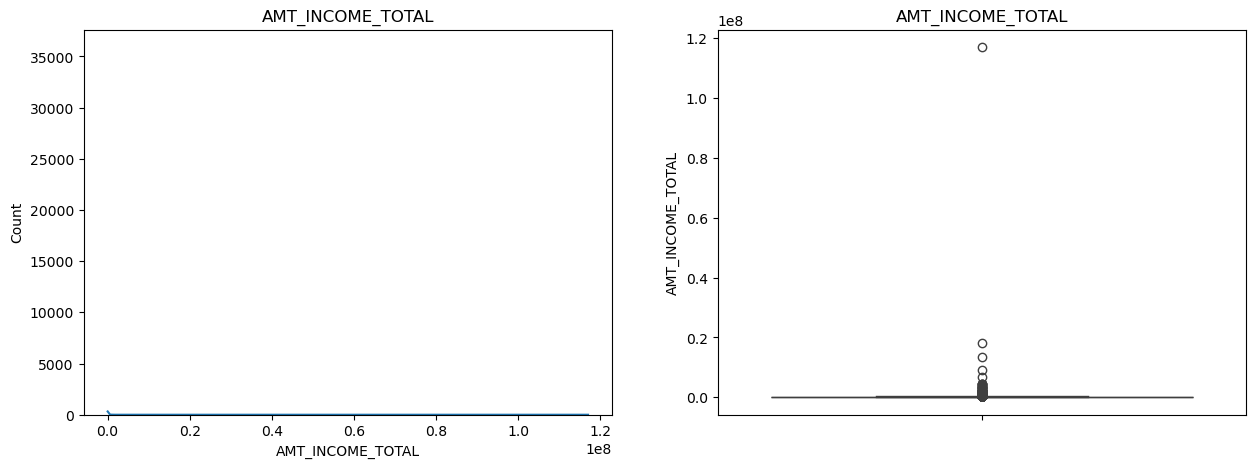

<Figure size 640x480 with 0 Axes>

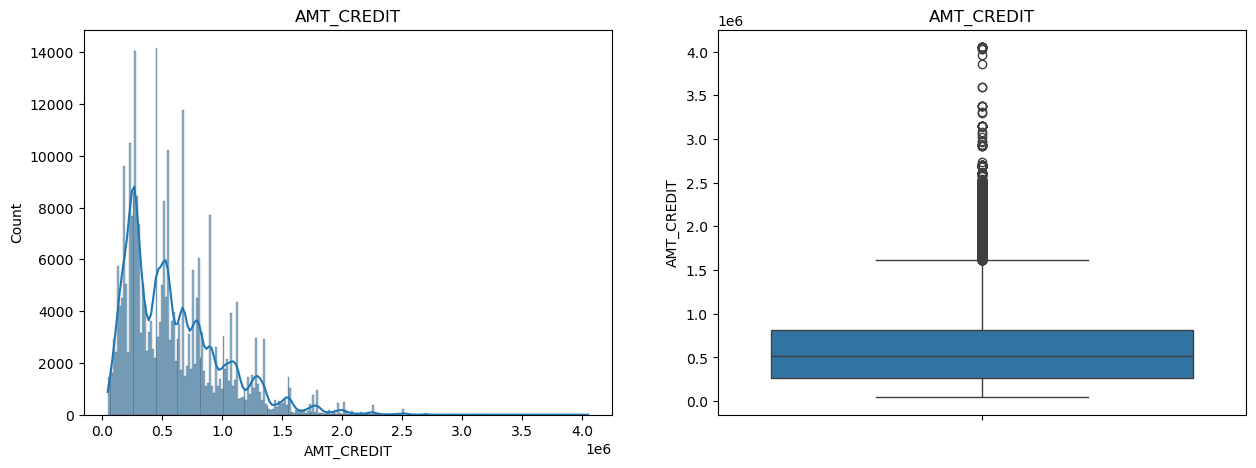

<Figure size 640x480 with 0 Axes>

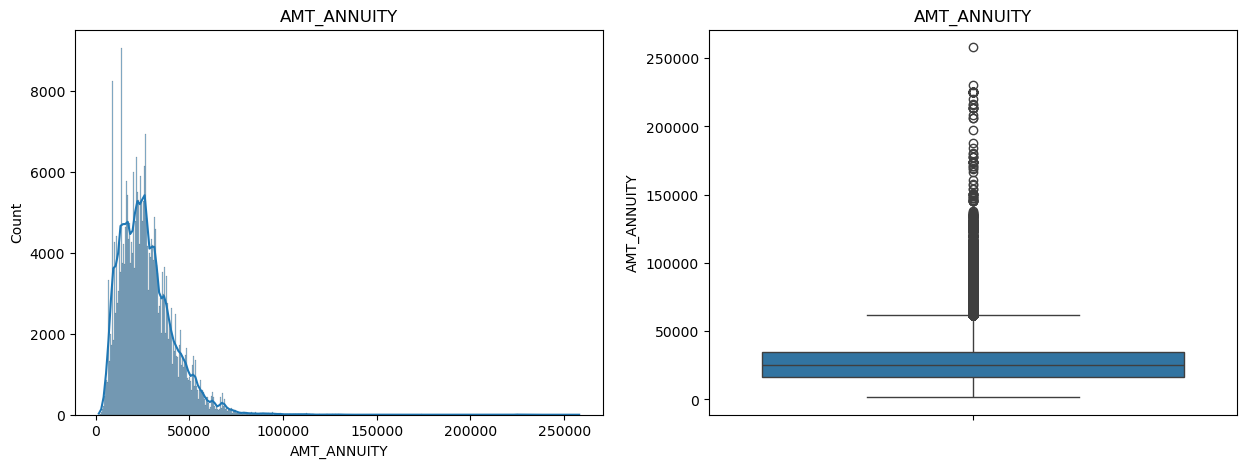

<Figure size 640x480 with 0 Axes>

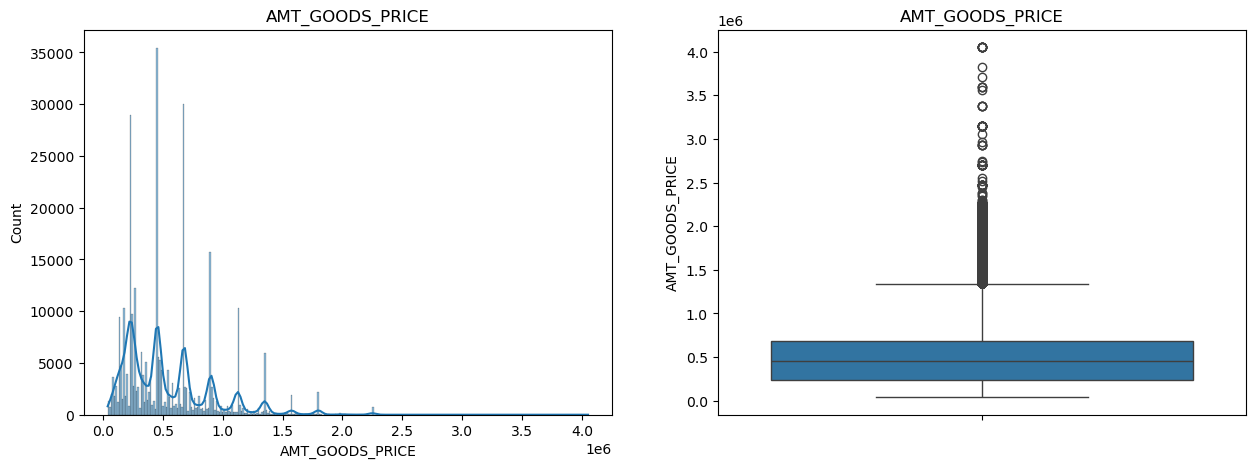

<Figure size 640x480 with 0 Axes>

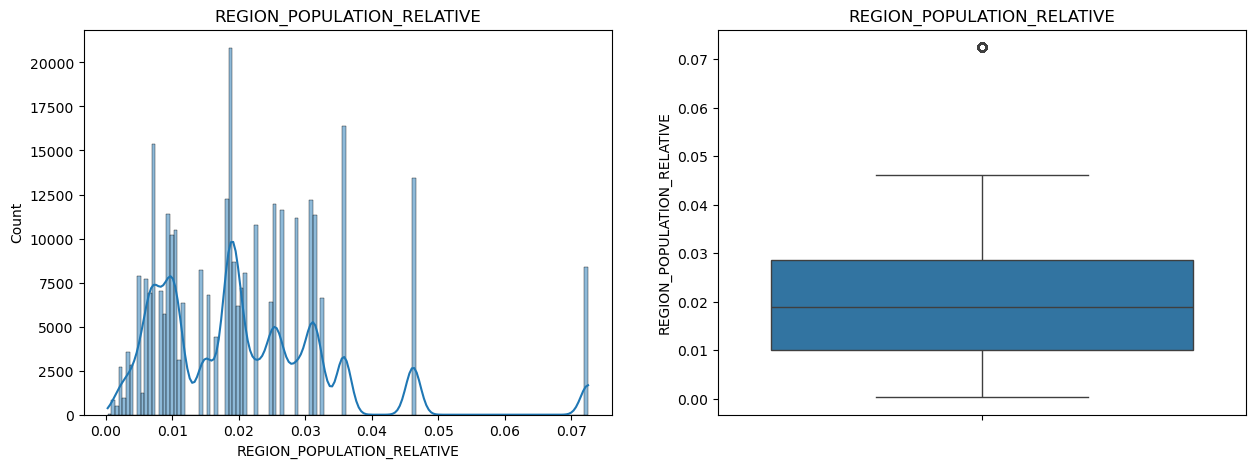

<Figure size 640x480 with 0 Axes>

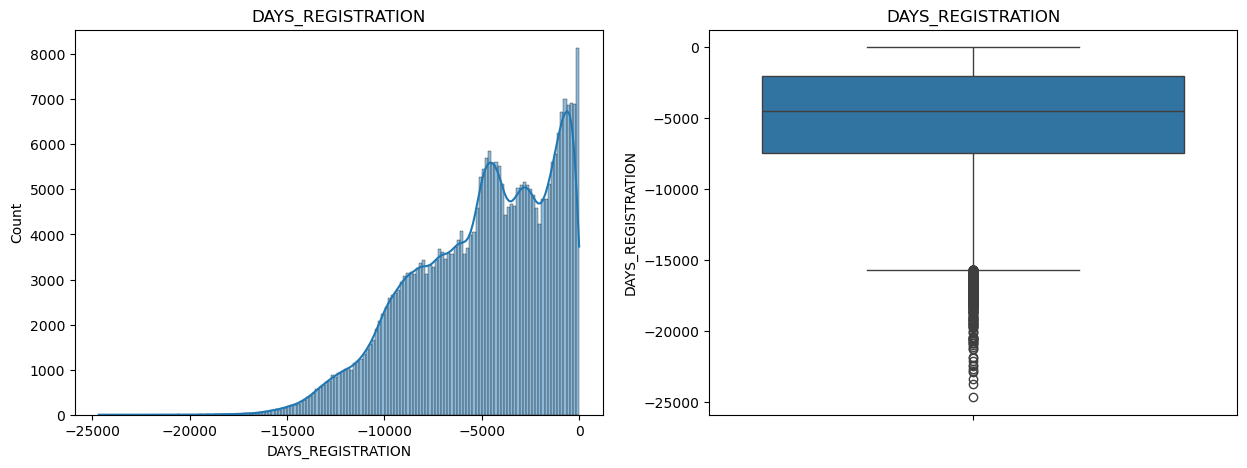

<Figure size 640x480 with 0 Axes>

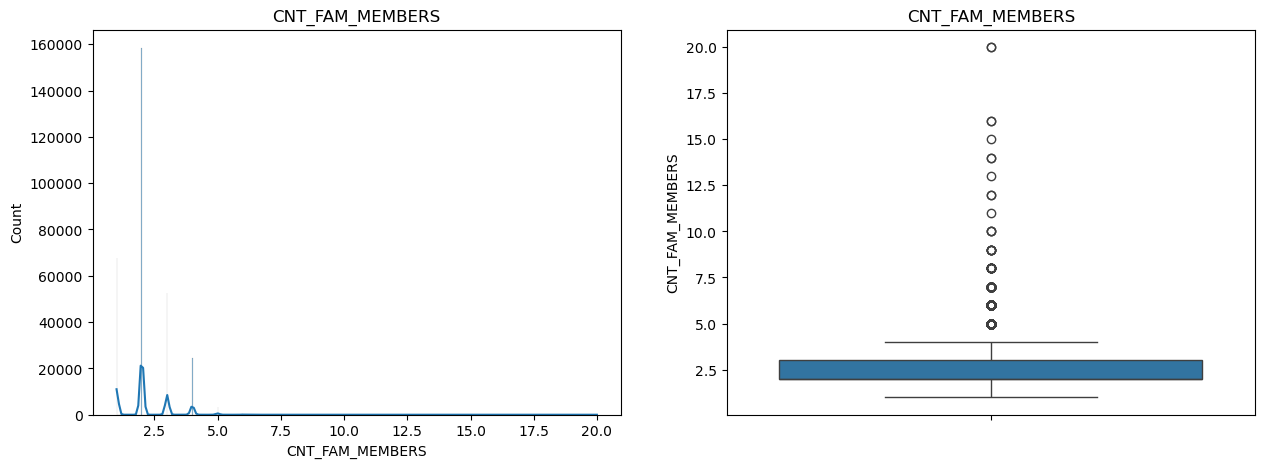

<Figure size 640x480 with 0 Axes>

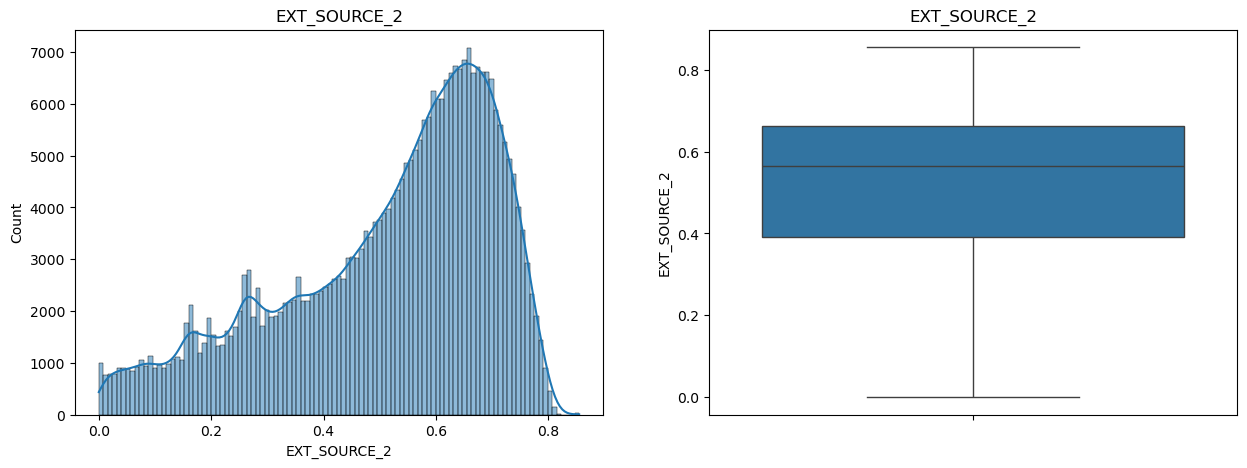

<Figure size 640x480 with 0 Axes>

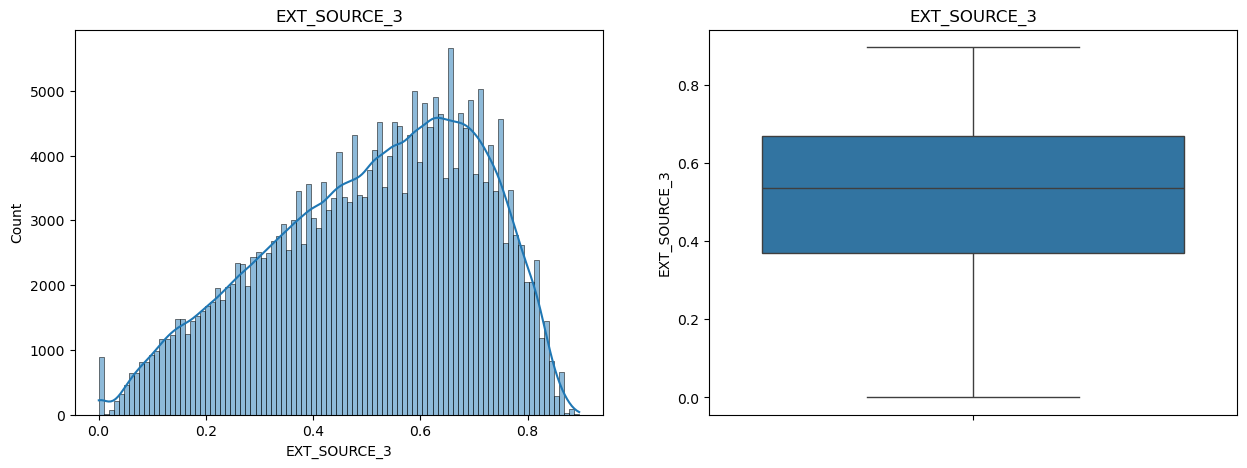

<Figure size 640x480 with 0 Axes>

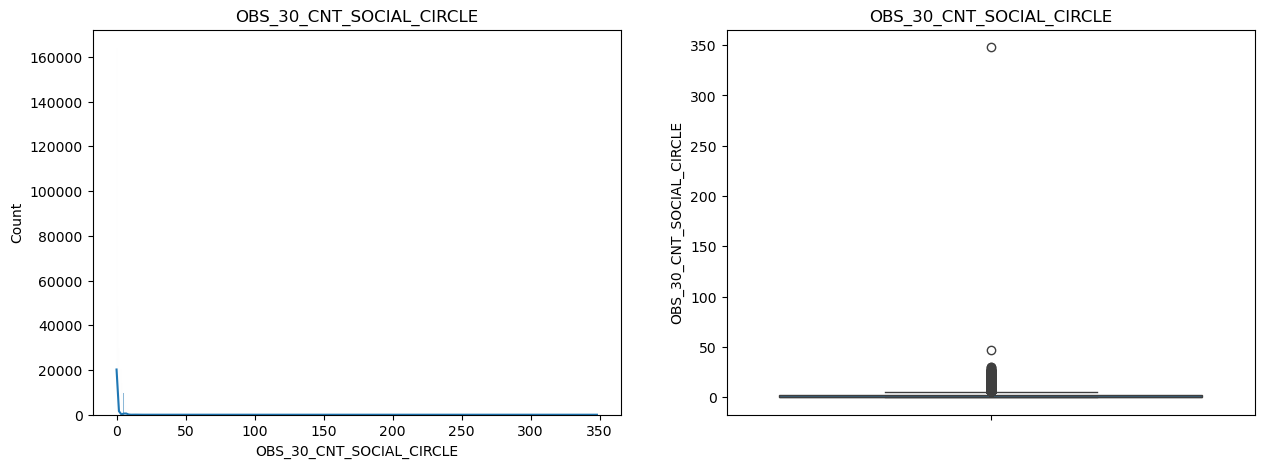

<Figure size 640x480 with 0 Axes>

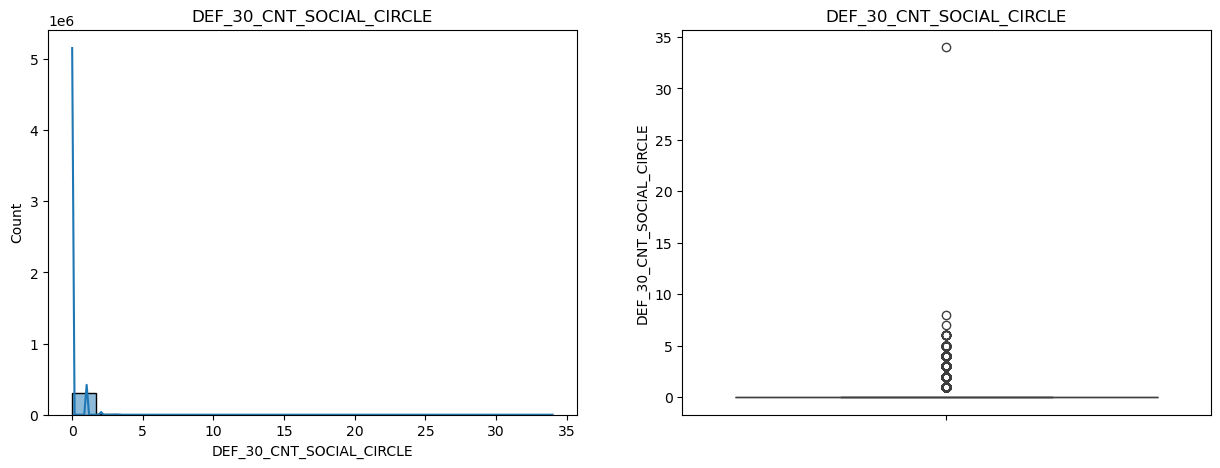

<Figure size 640x480 with 0 Axes>

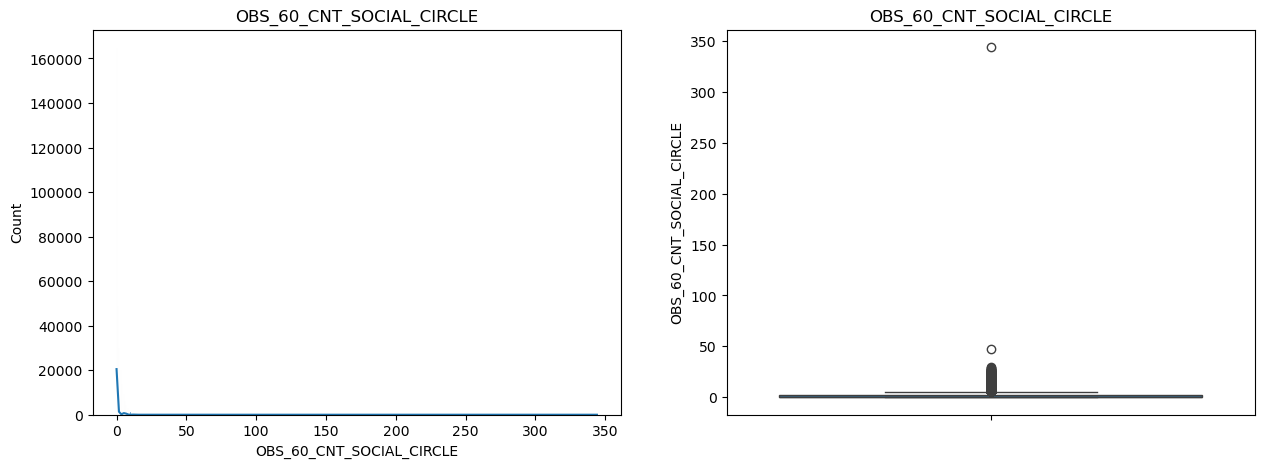

<Figure size 640x480 with 0 Axes>

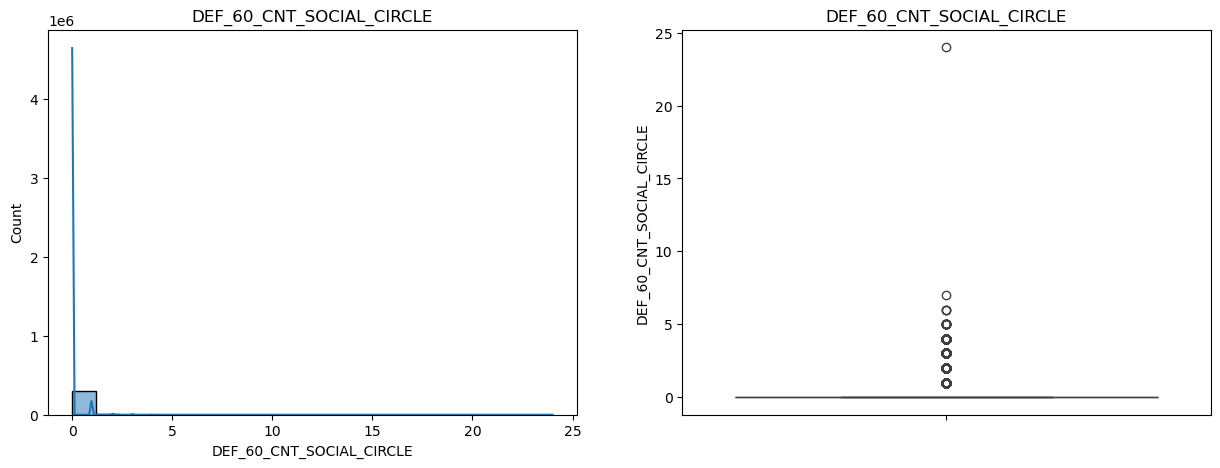

<Figure size 640x480 with 0 Axes>

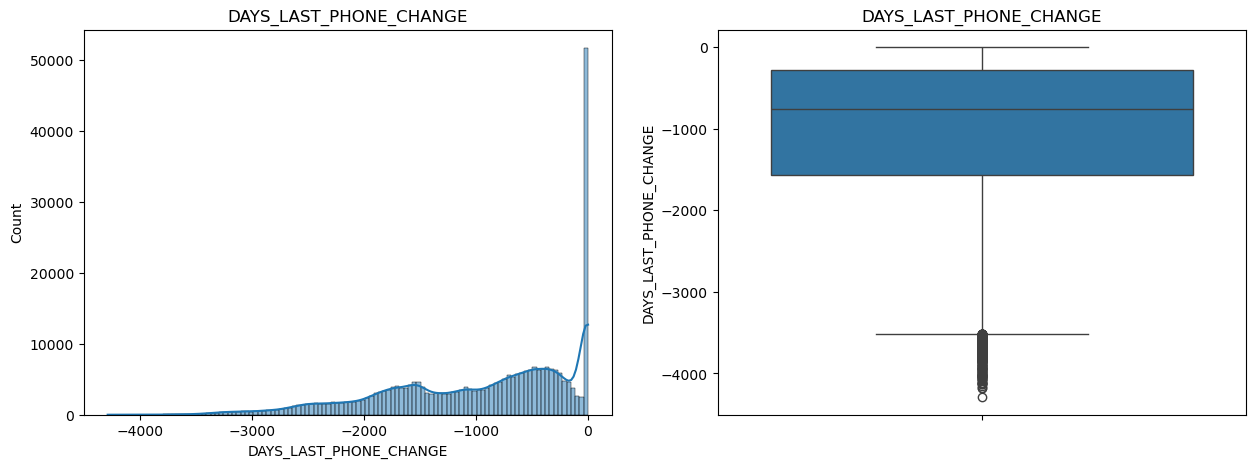

<Figure size 640x480 with 0 Axes>

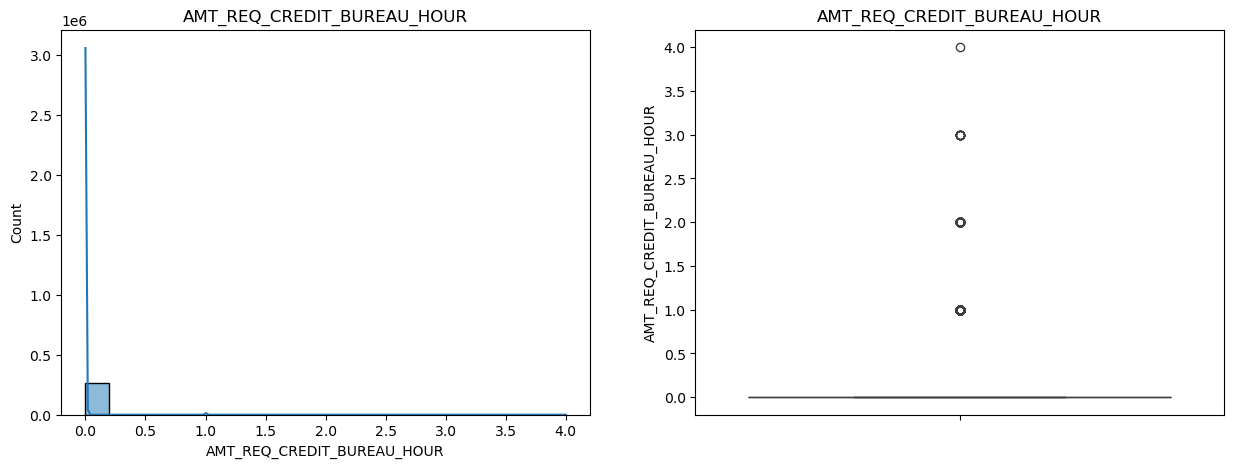

<Figure size 640x480 with 0 Axes>

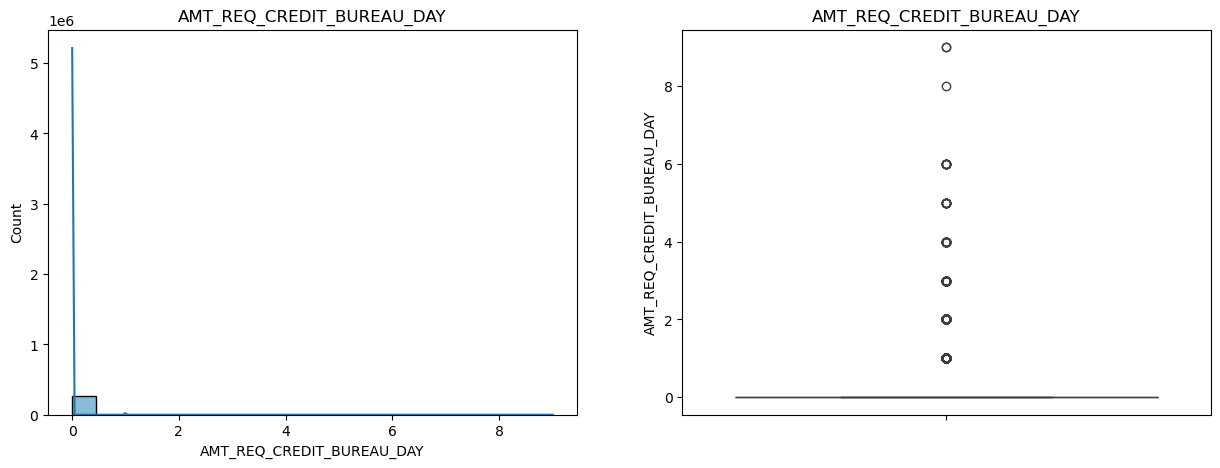

<Figure size 640x480 with 0 Axes>

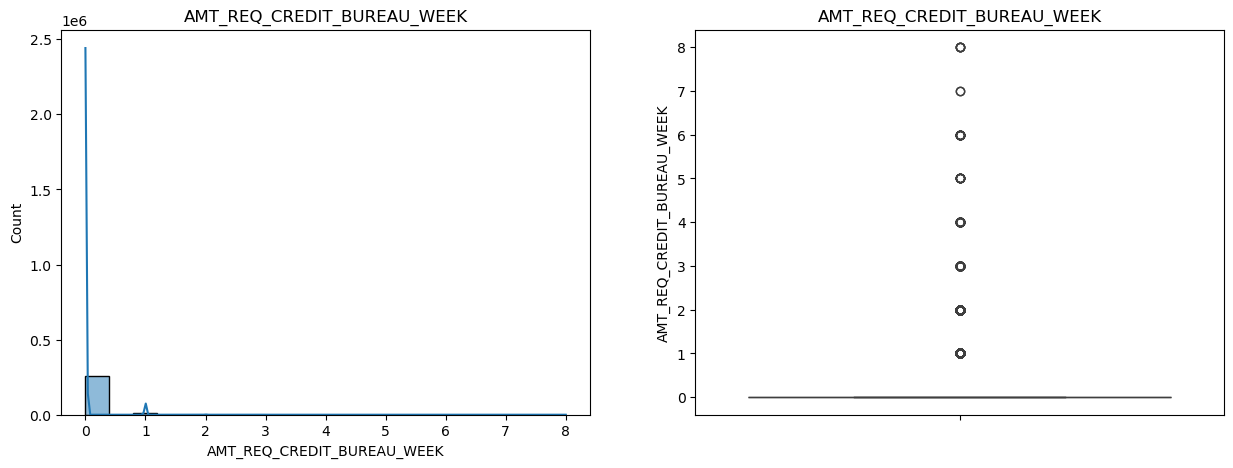

<Figure size 640x480 with 0 Axes>

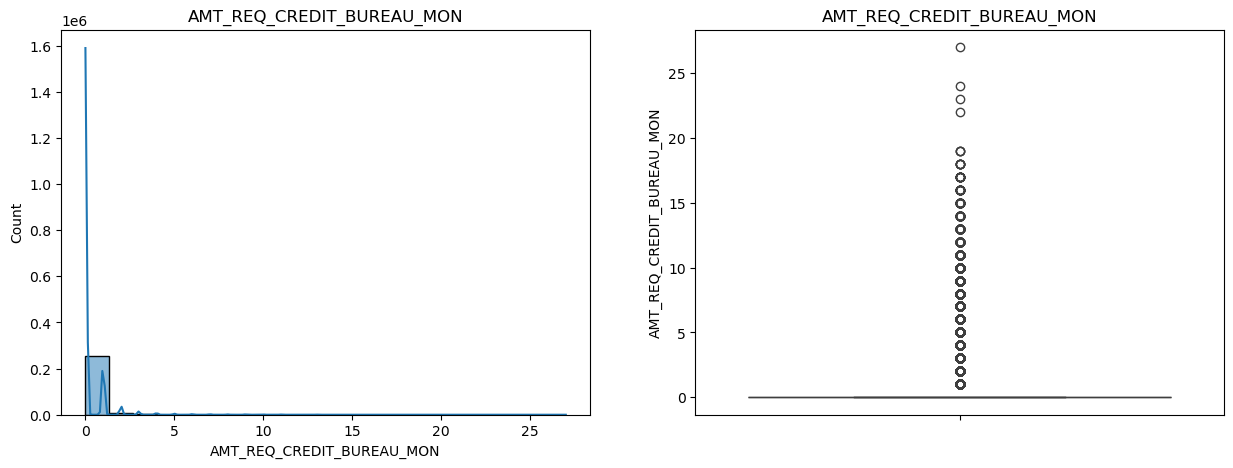

<Figure size 640x480 with 0 Axes>

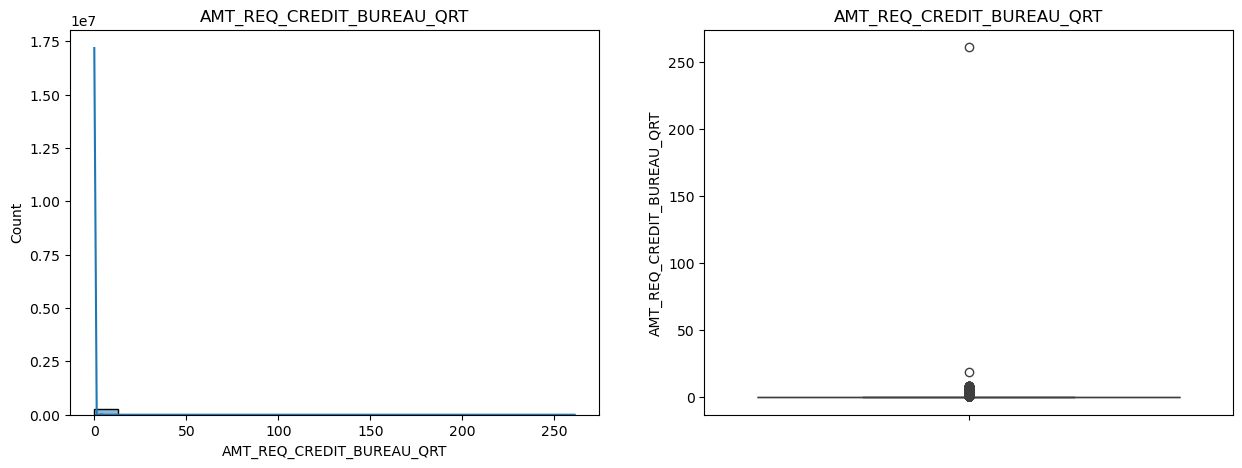

<Figure size 640x480 with 0 Axes>

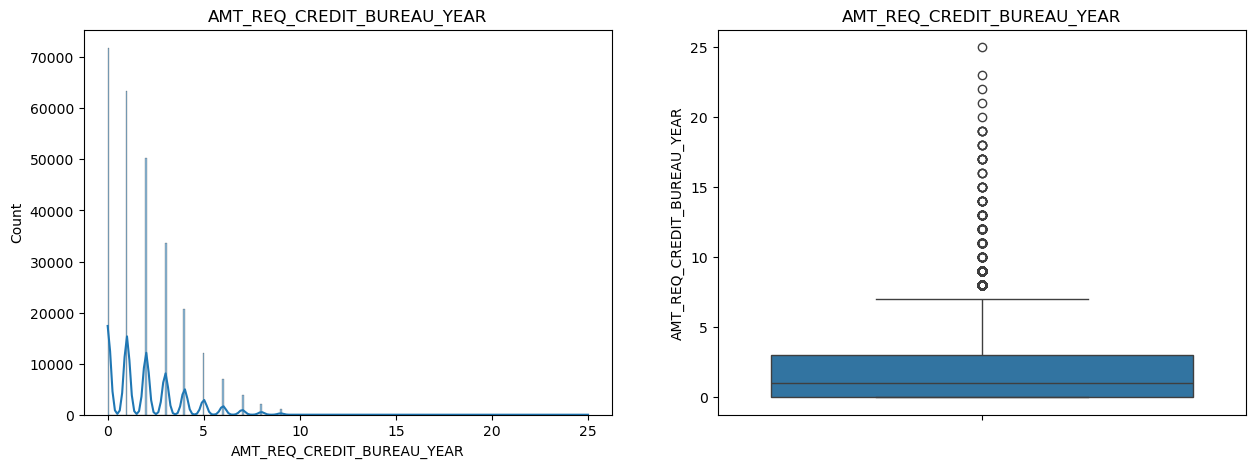

<Figure size 640x480 with 0 Axes>

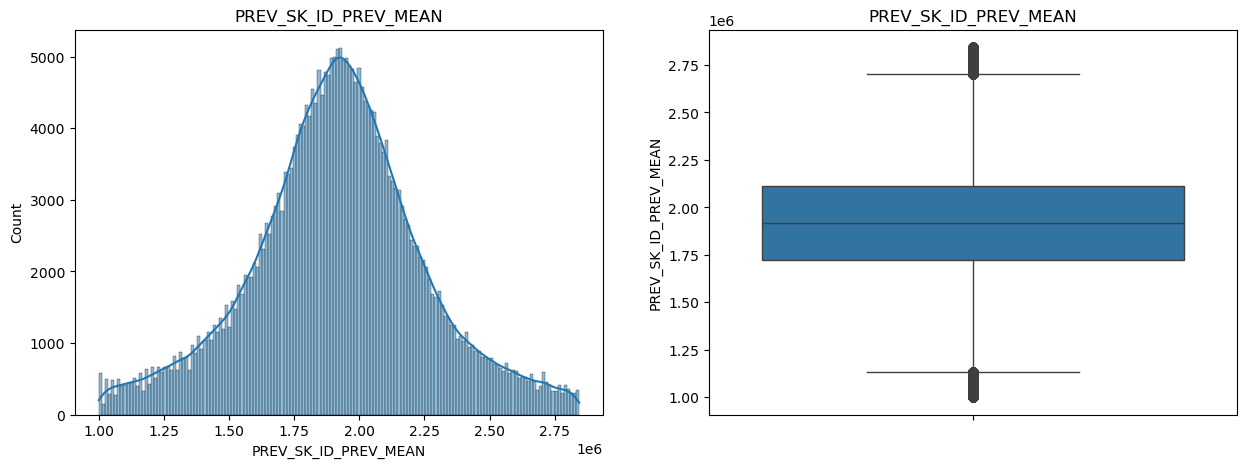

<Figure size 640x480 with 0 Axes>

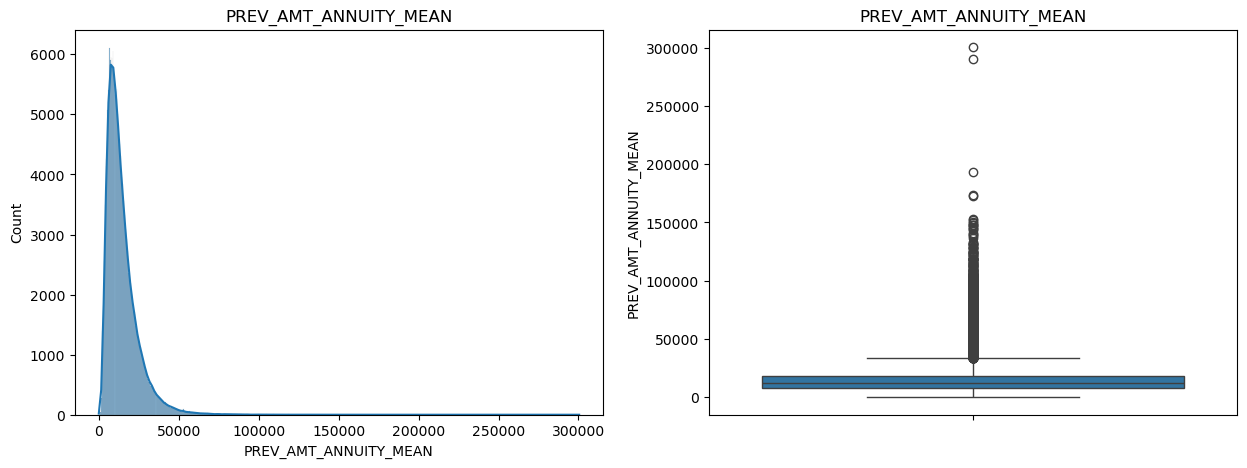

<Figure size 640x480 with 0 Axes>

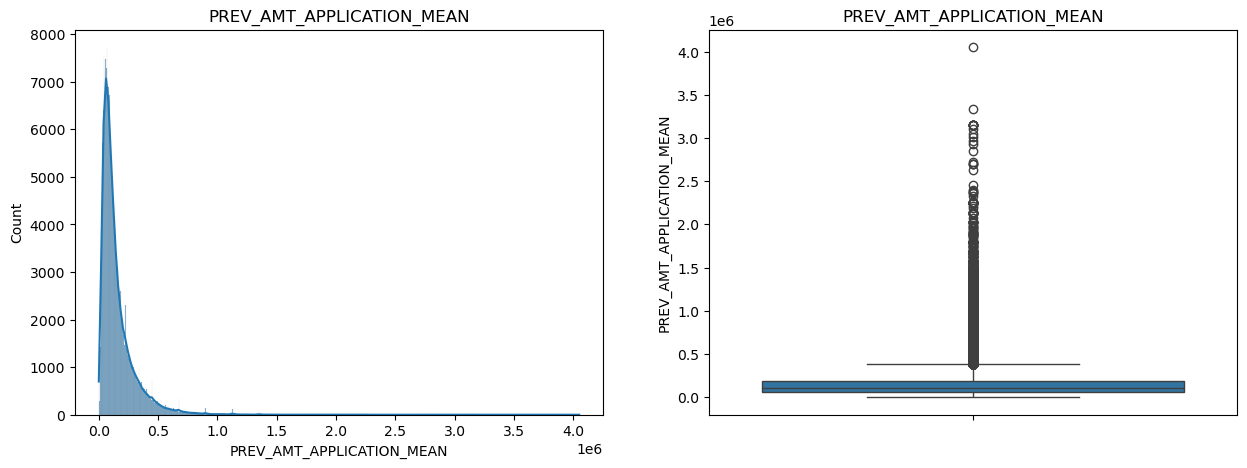

<Figure size 640x480 with 0 Axes>

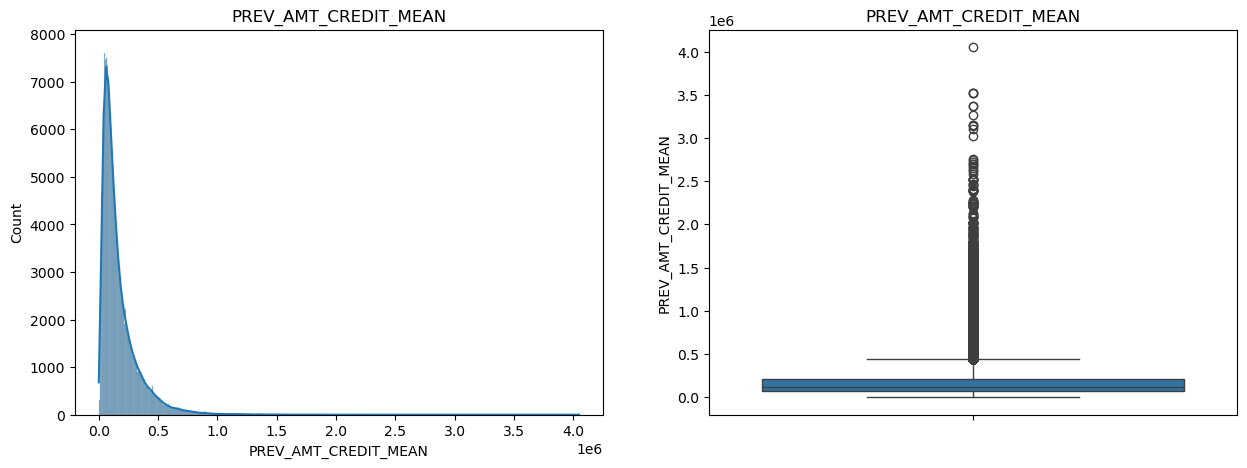

<Figure size 640x480 with 0 Axes>

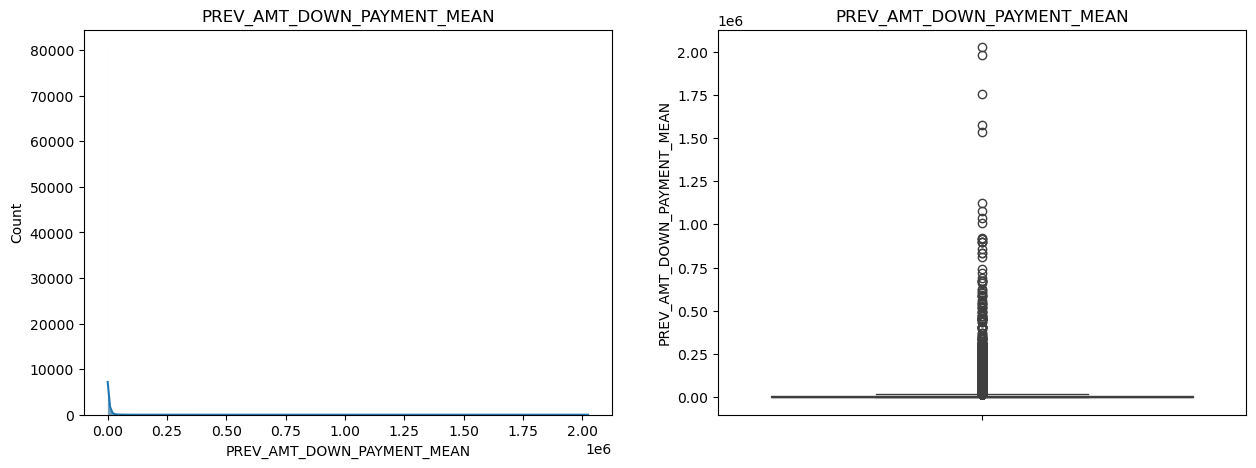

<Figure size 640x480 with 0 Axes>

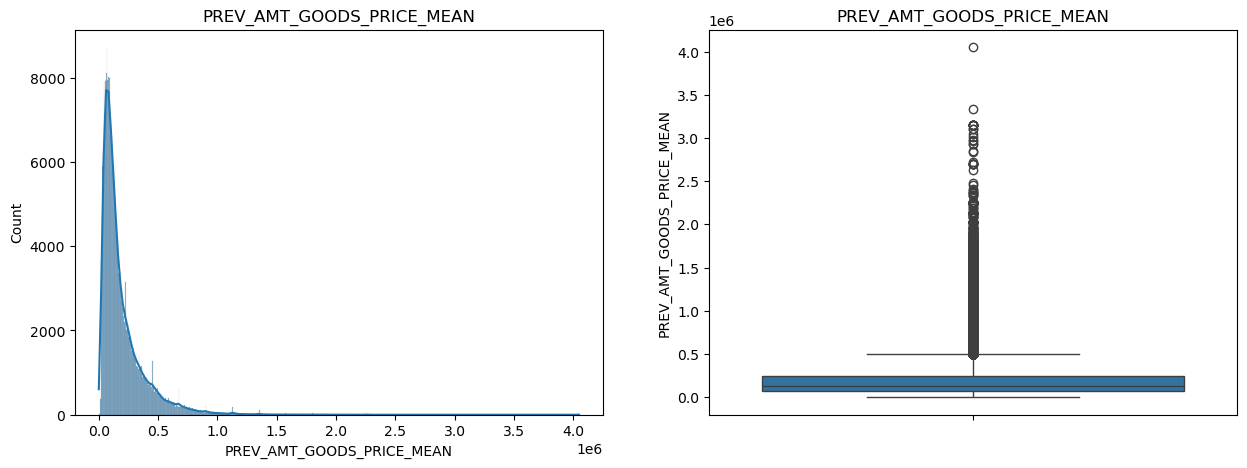

<Figure size 640x480 with 0 Axes>

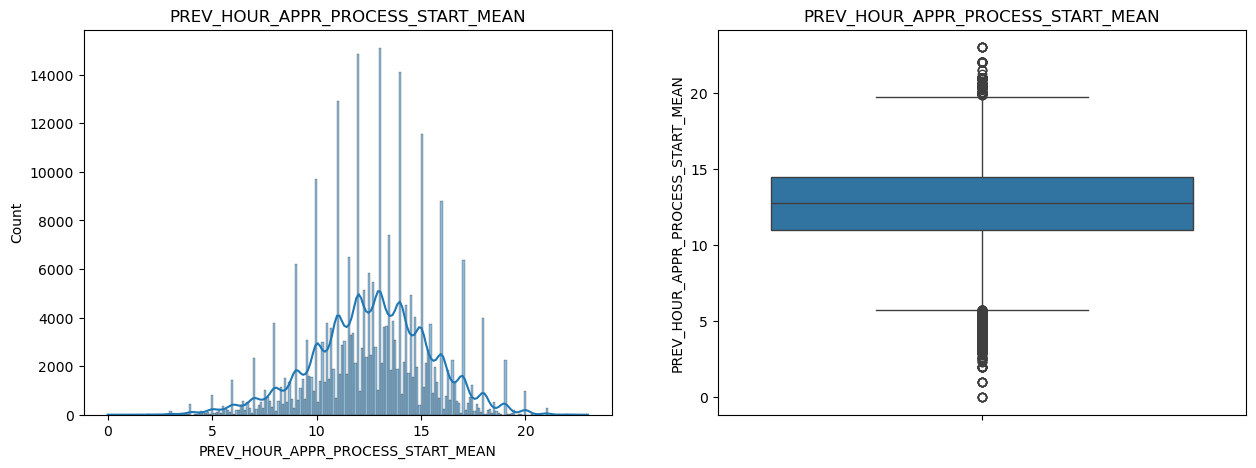

<Figure size 640x480 with 0 Axes>

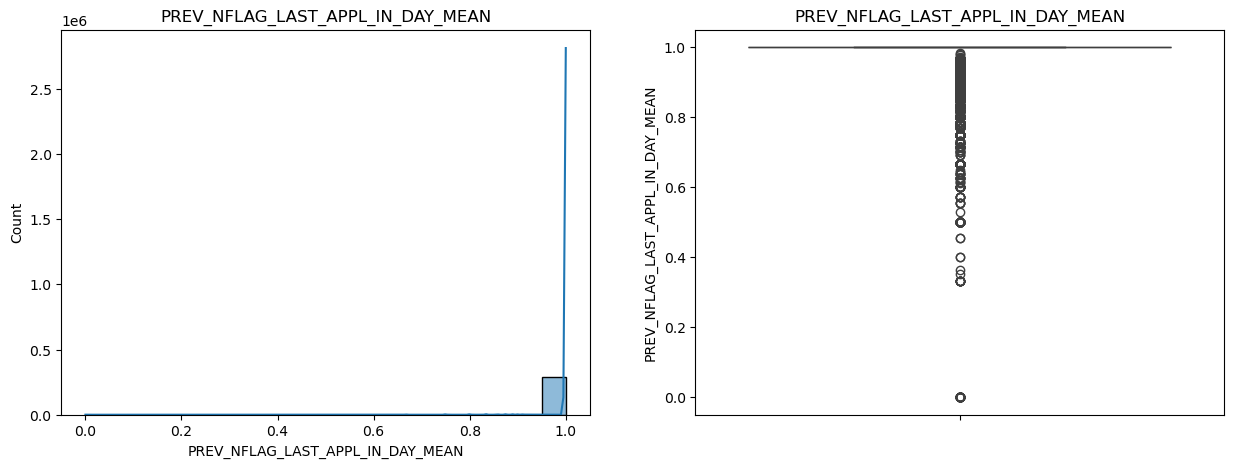

<Figure size 640x480 with 0 Axes>

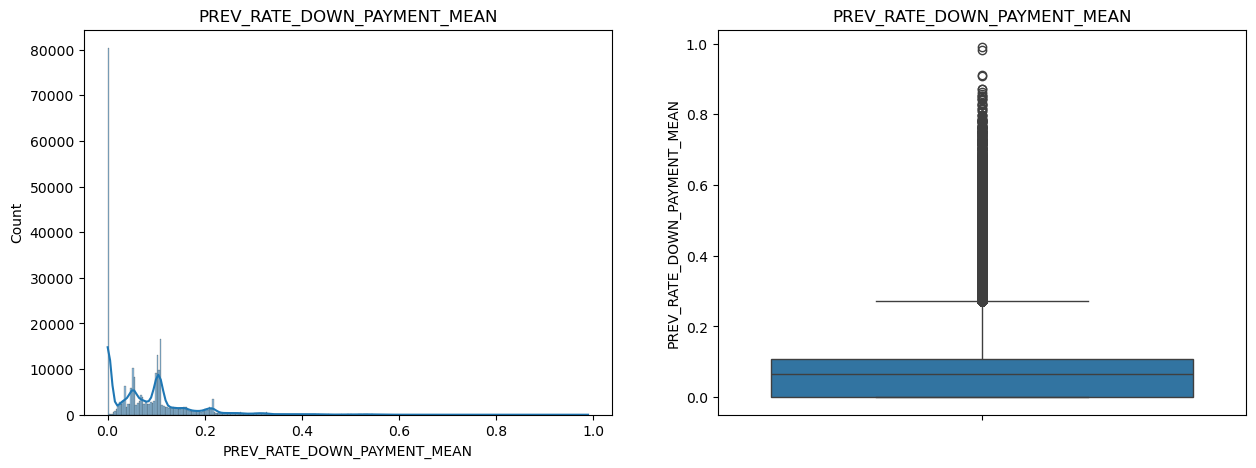

<Figure size 640x480 with 0 Axes>

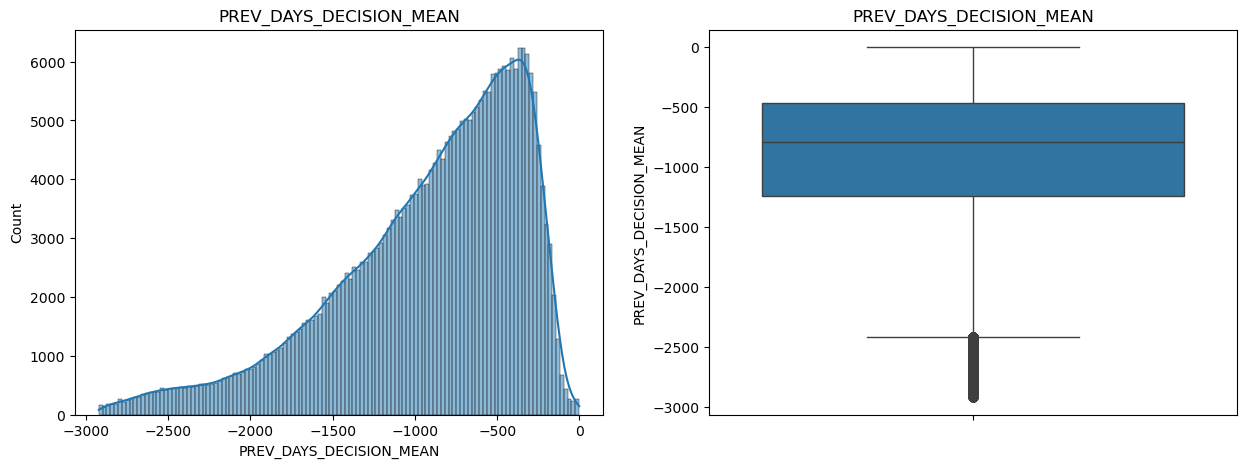

<Figure size 640x480 with 0 Axes>

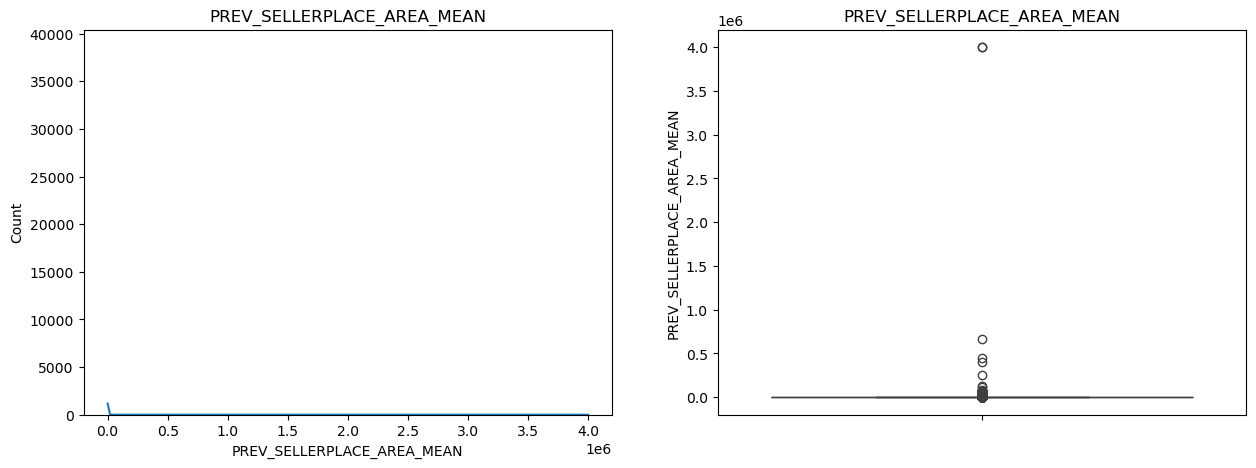

<Figure size 640x480 with 0 Axes>

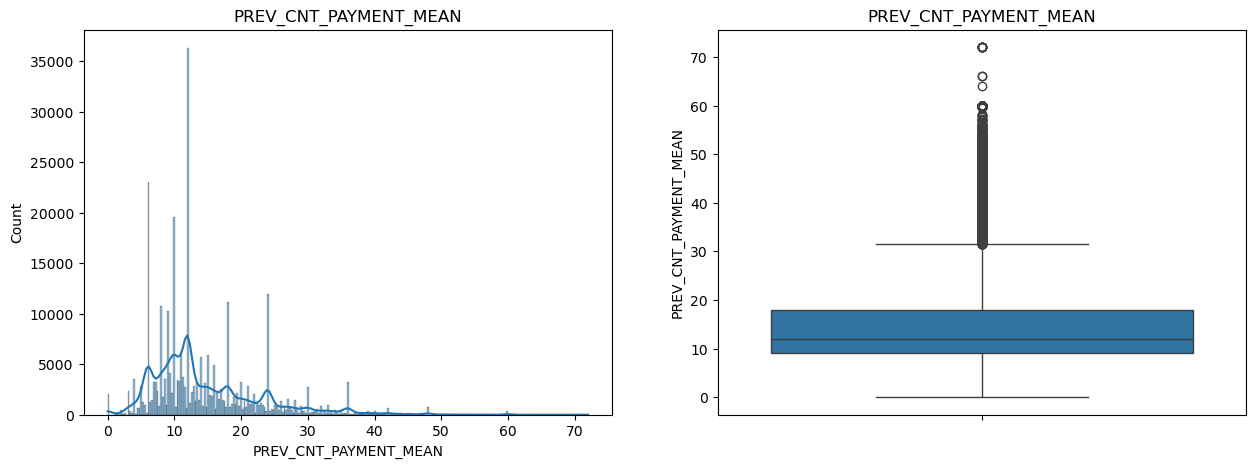

<Figure size 640x480 with 0 Axes>

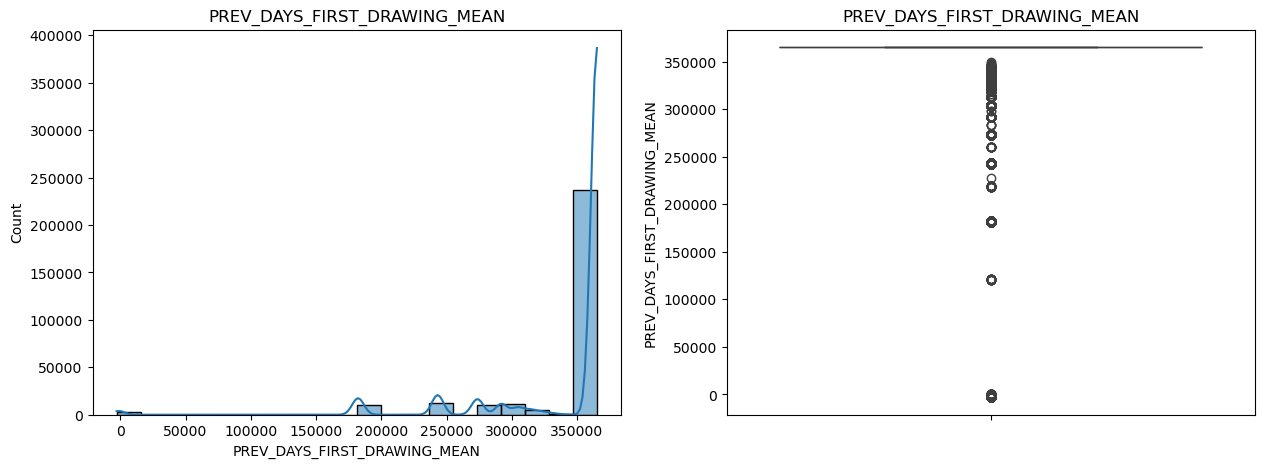

<Figure size 640x480 with 0 Axes>

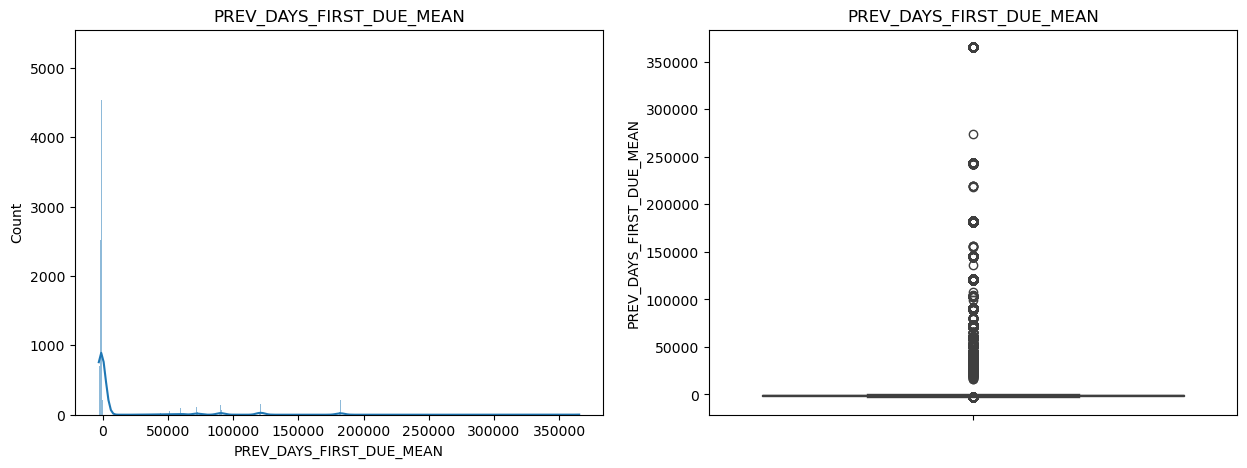

<Figure size 640x480 with 0 Axes>

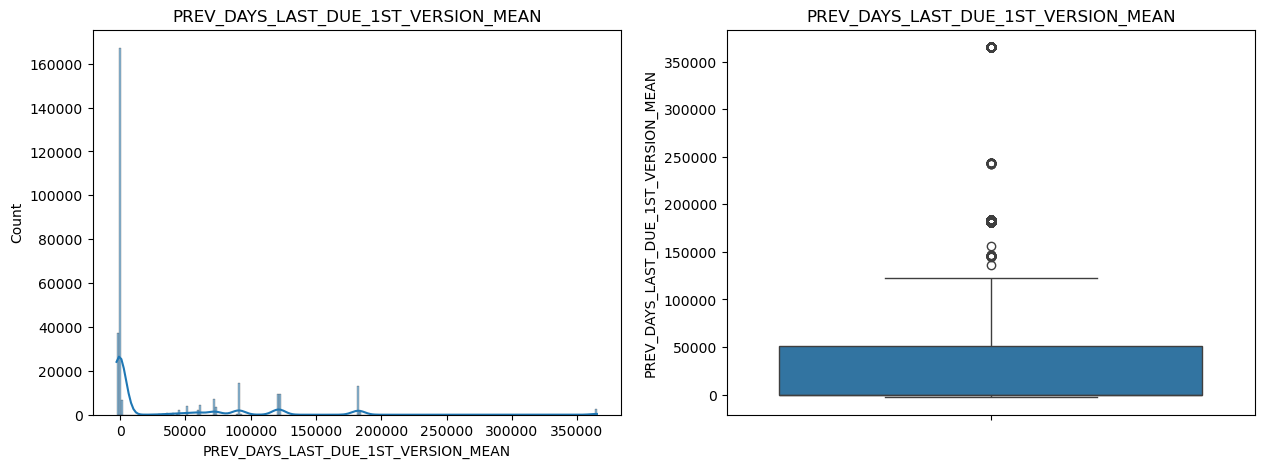

<Figure size 640x480 with 0 Axes>

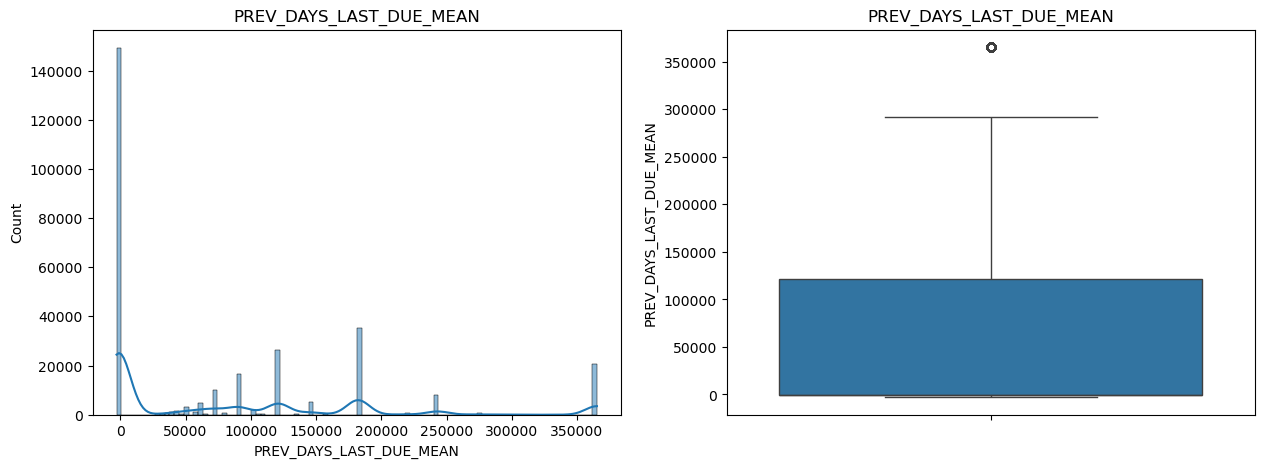

<Figure size 640x480 with 0 Axes>

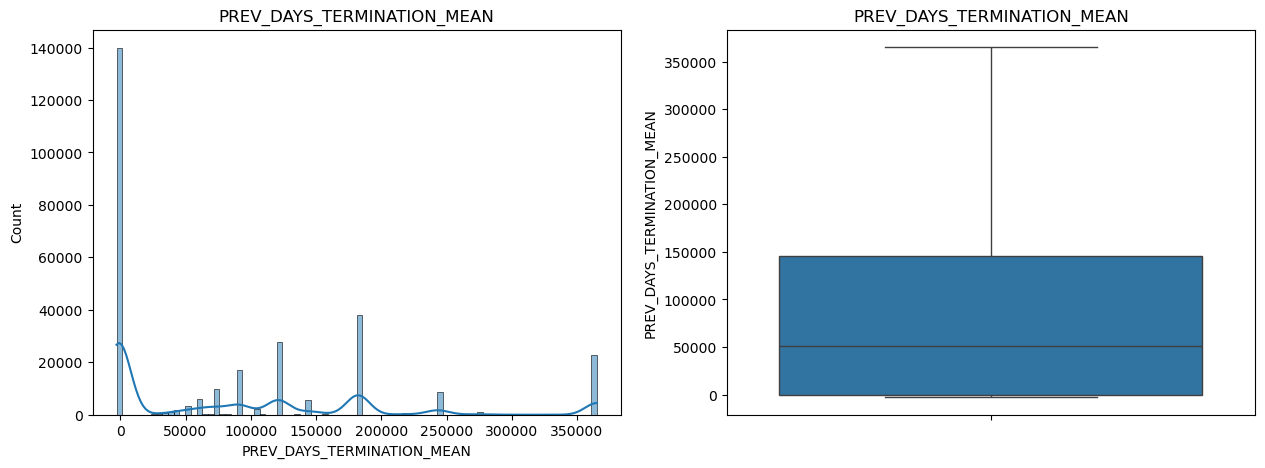

<Figure size 640x480 with 0 Axes>

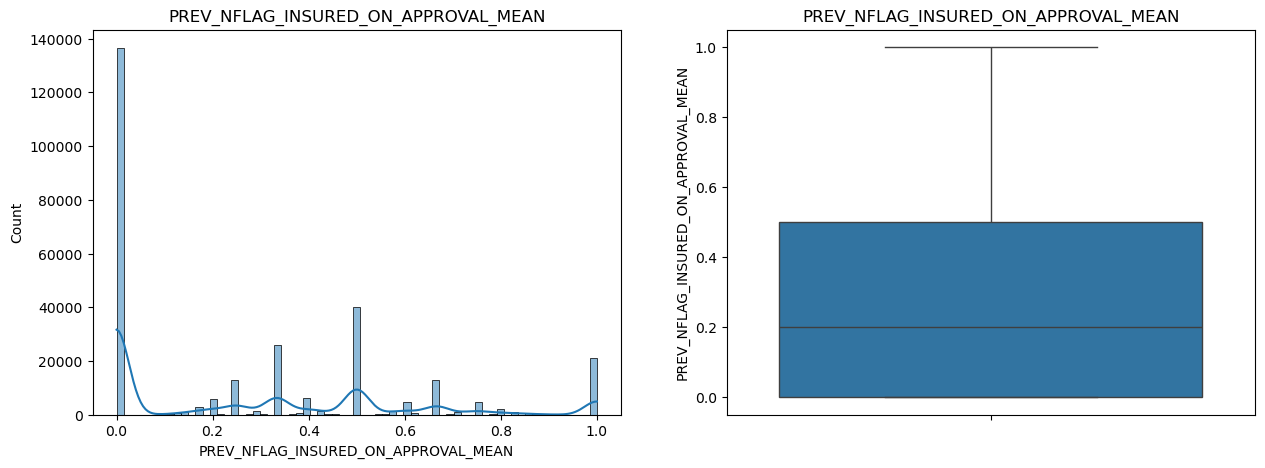

<Figure size 640x480 with 0 Axes>

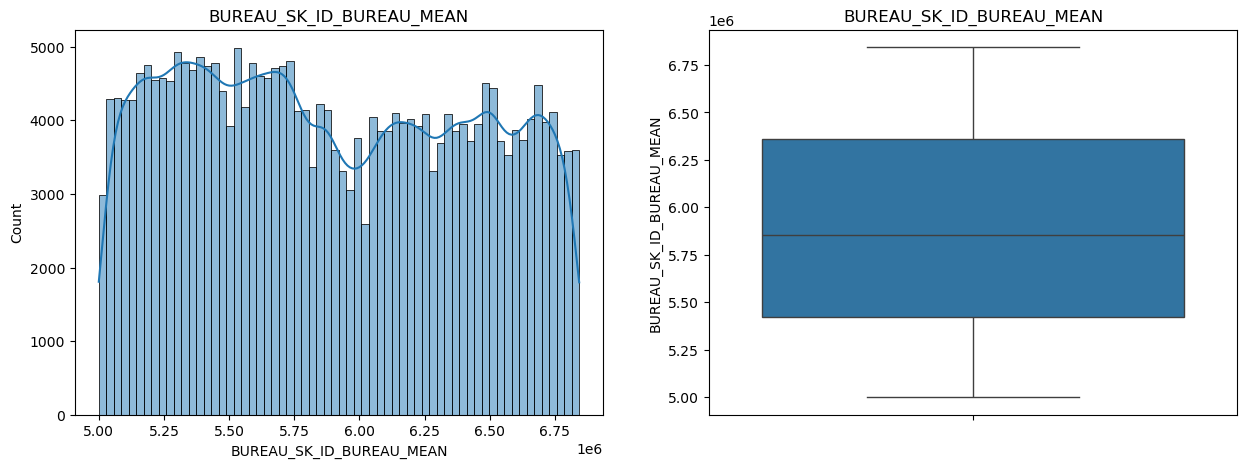

<Figure size 640x480 with 0 Axes>

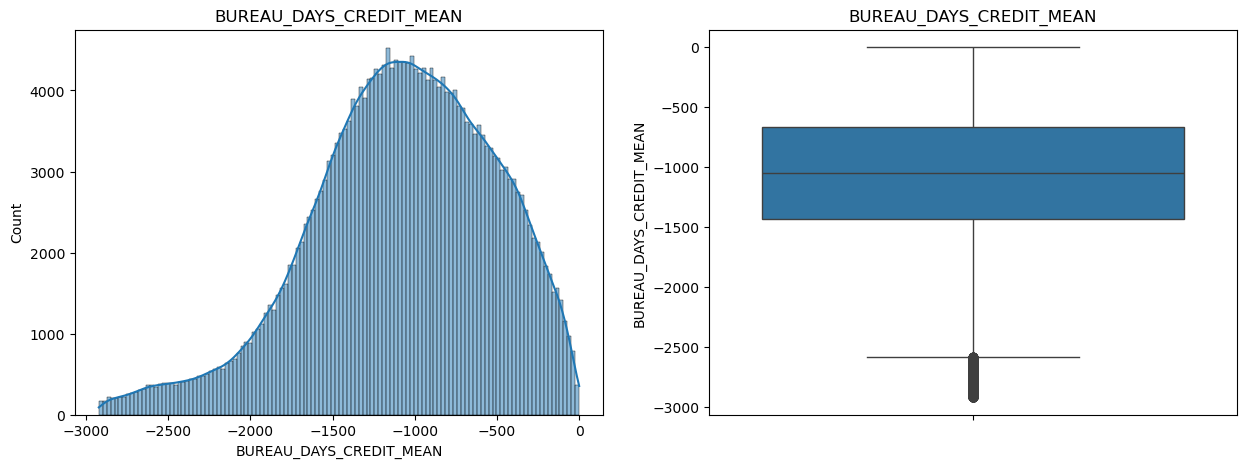

<Figure size 640x480 with 0 Axes>

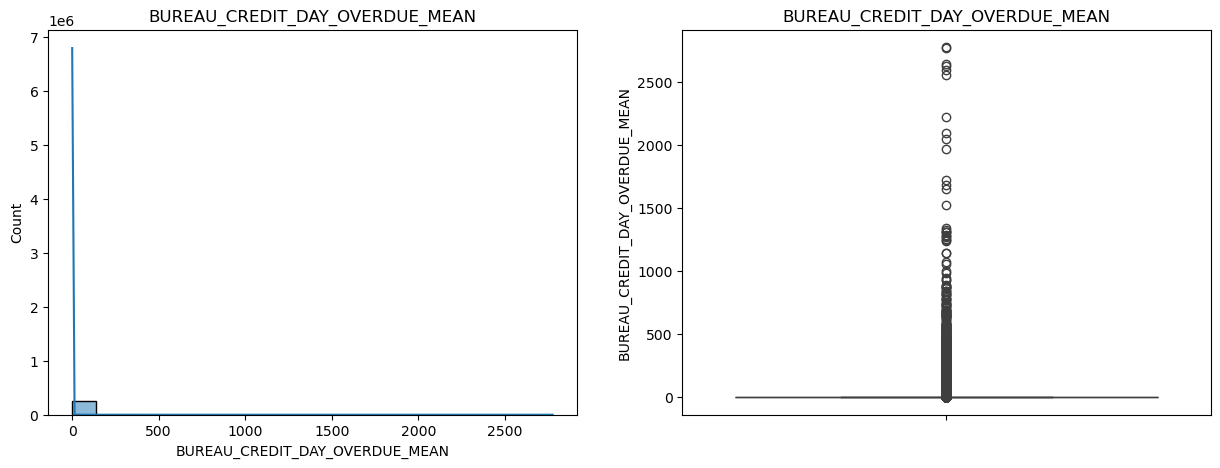

<Figure size 640x480 with 0 Axes>

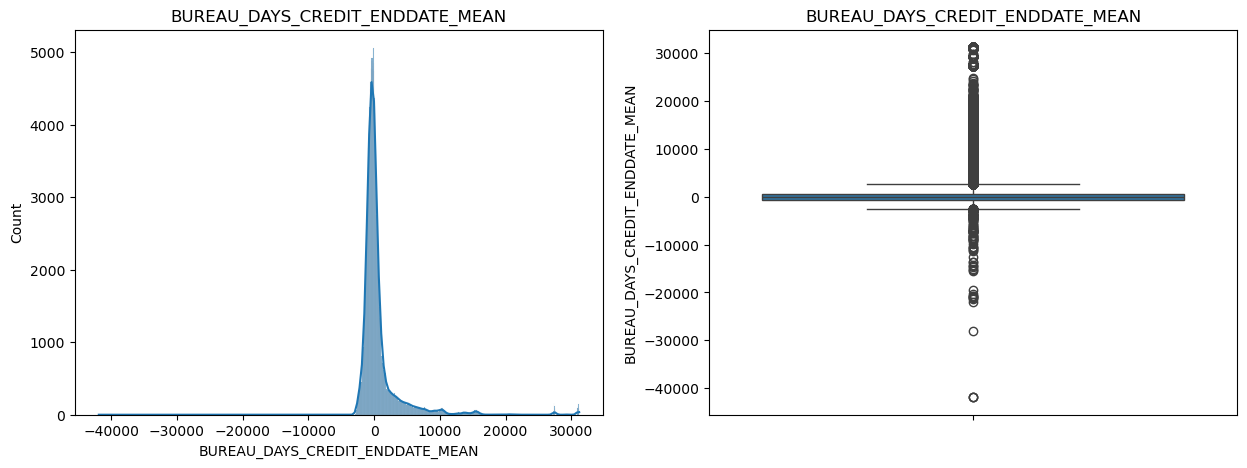

<Figure size 640x480 with 0 Axes>

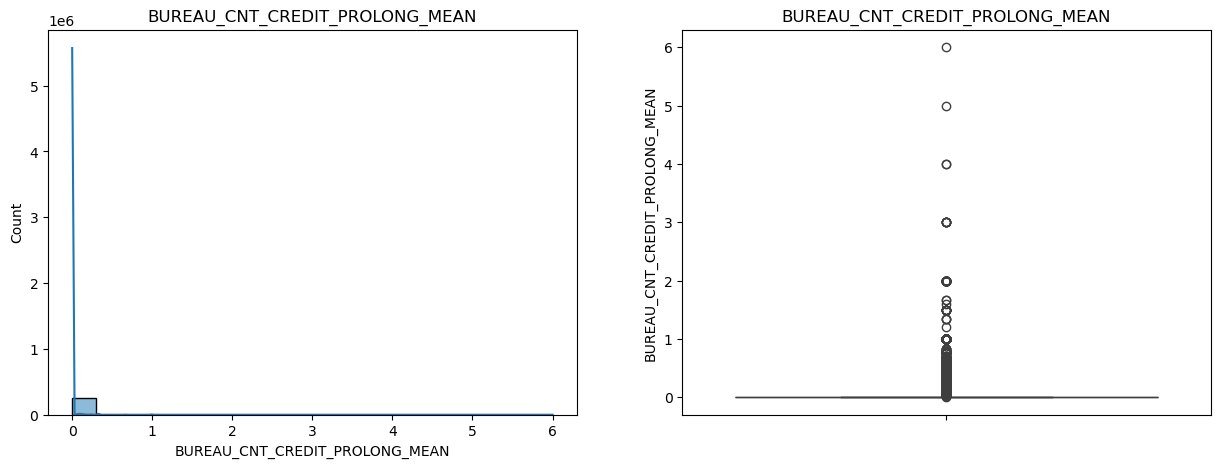

<Figure size 640x480 with 0 Axes>

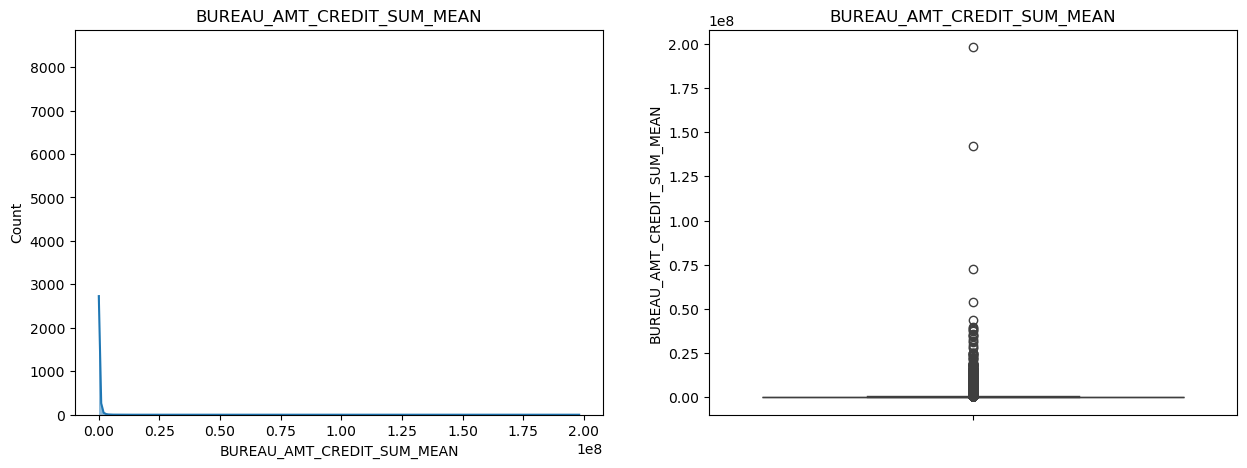

<Figure size 640x480 with 0 Axes>

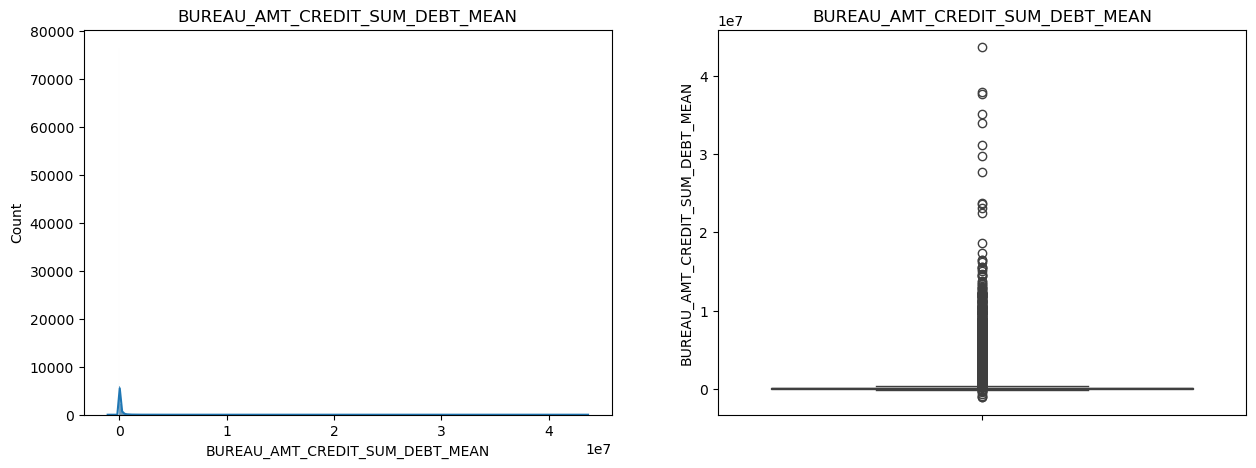

<Figure size 640x480 with 0 Axes>

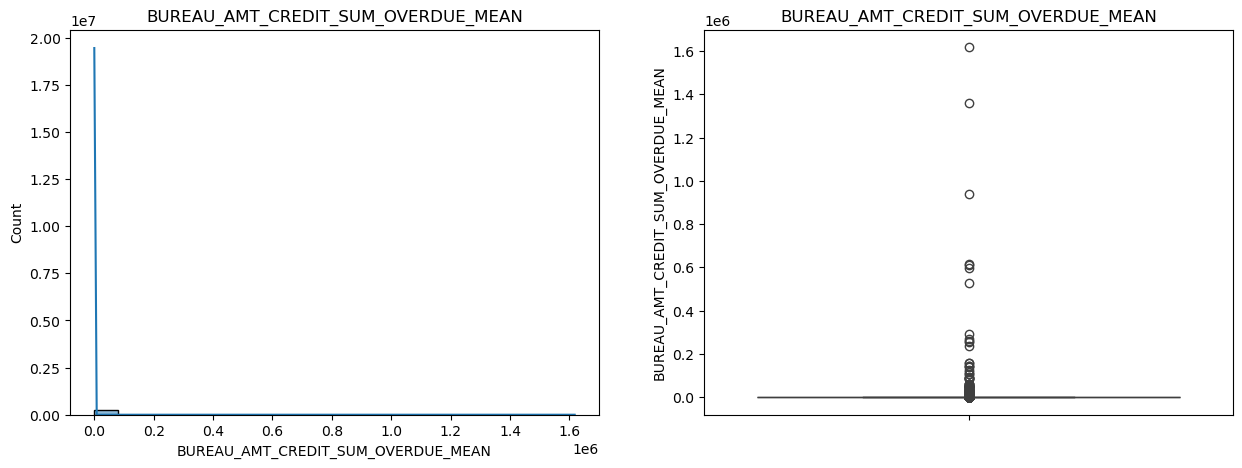

<Figure size 640x480 with 0 Axes>

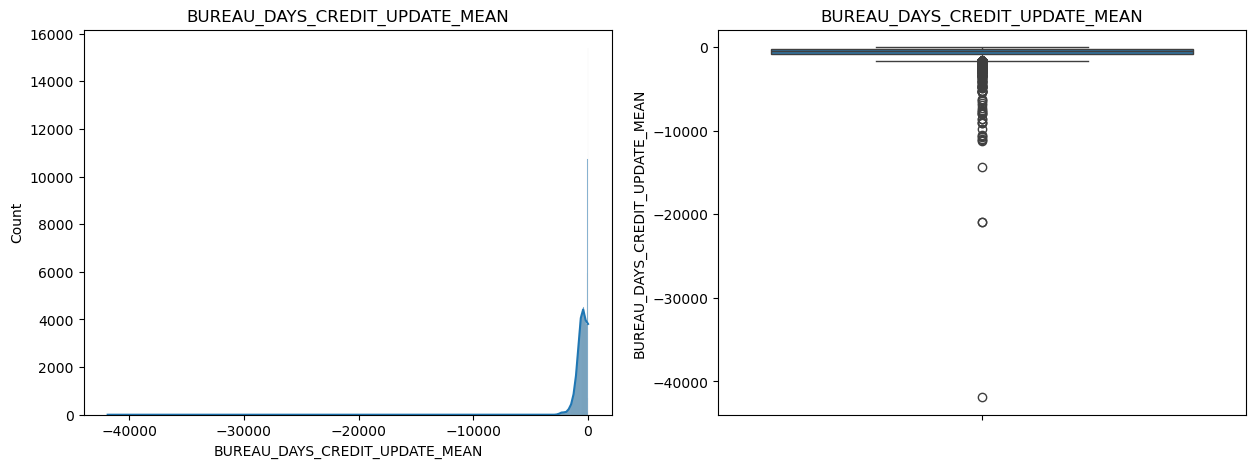

<Figure size 640x480 with 0 Axes>

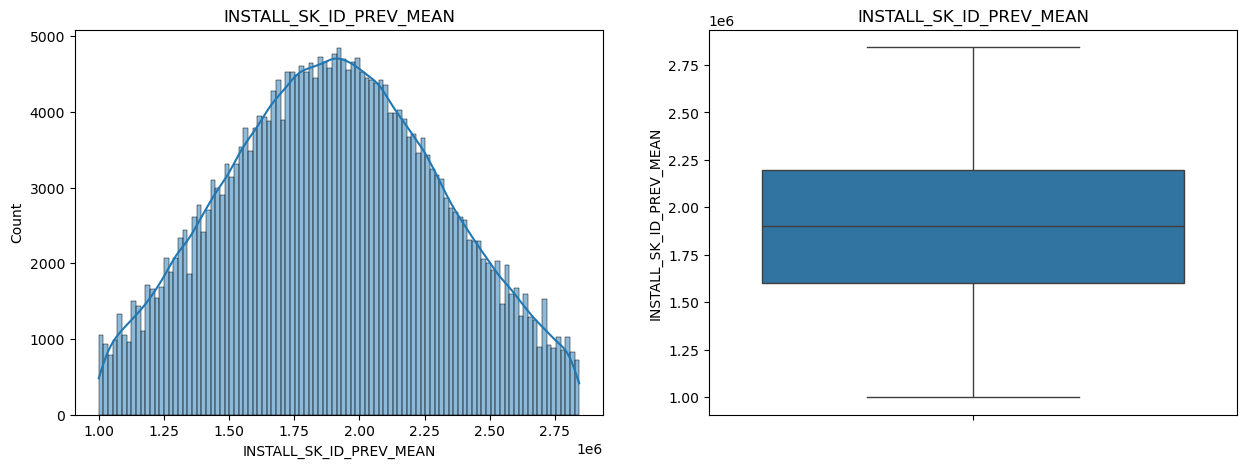

<Figure size 640x480 with 0 Axes>

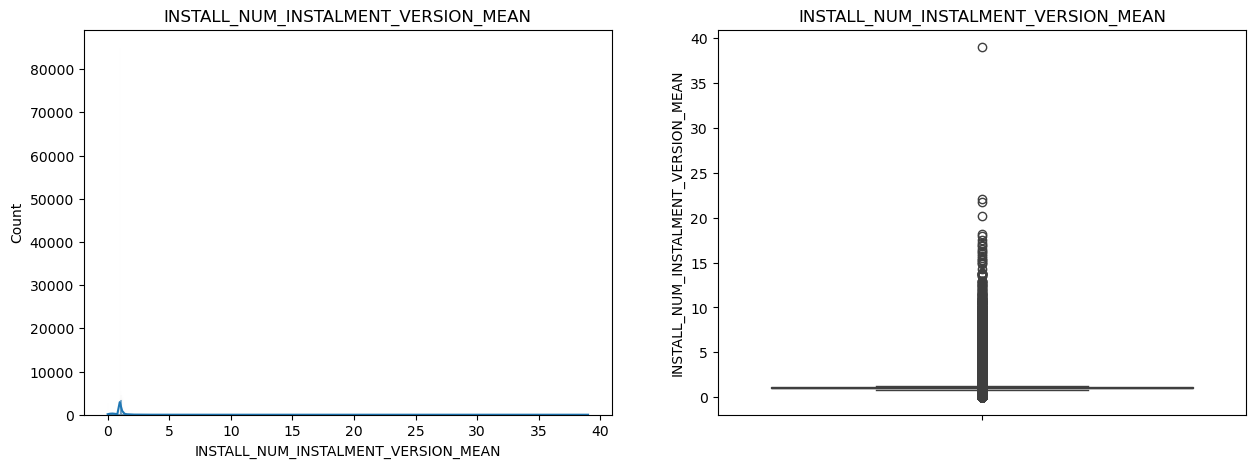

<Figure size 640x480 with 0 Axes>

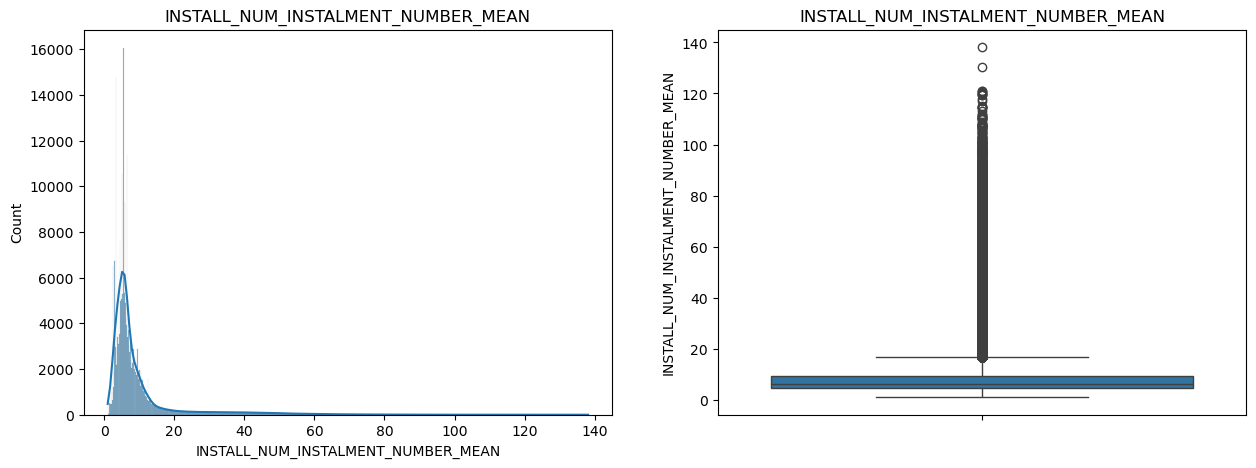

<Figure size 640x480 with 0 Axes>

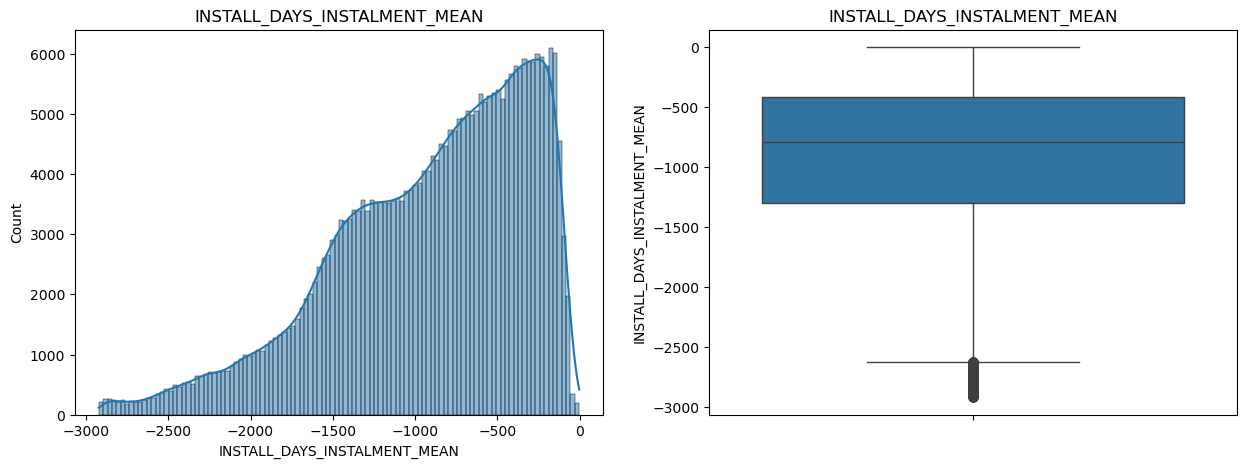

<Figure size 640x480 with 0 Axes>

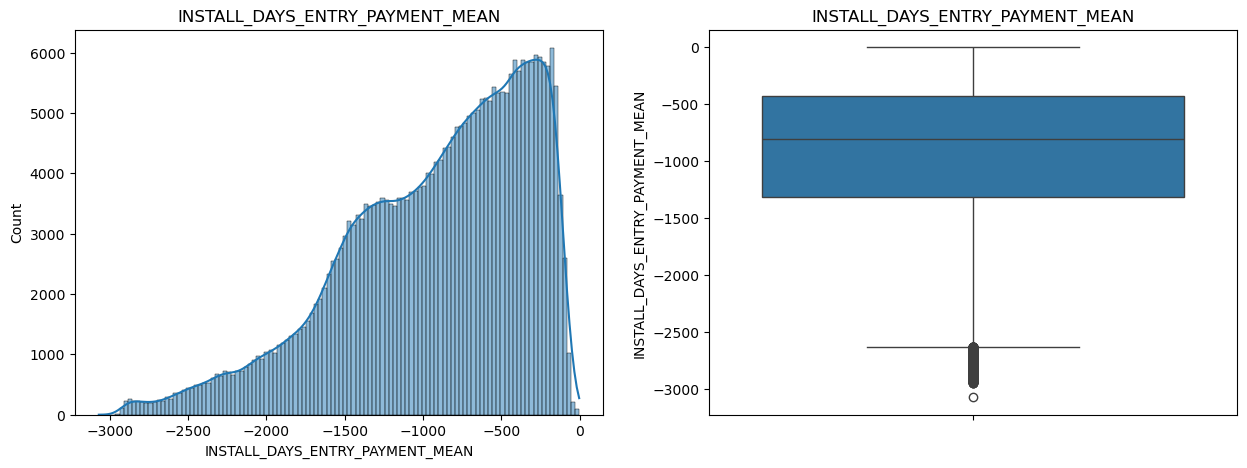

<Figure size 640x480 with 0 Axes>

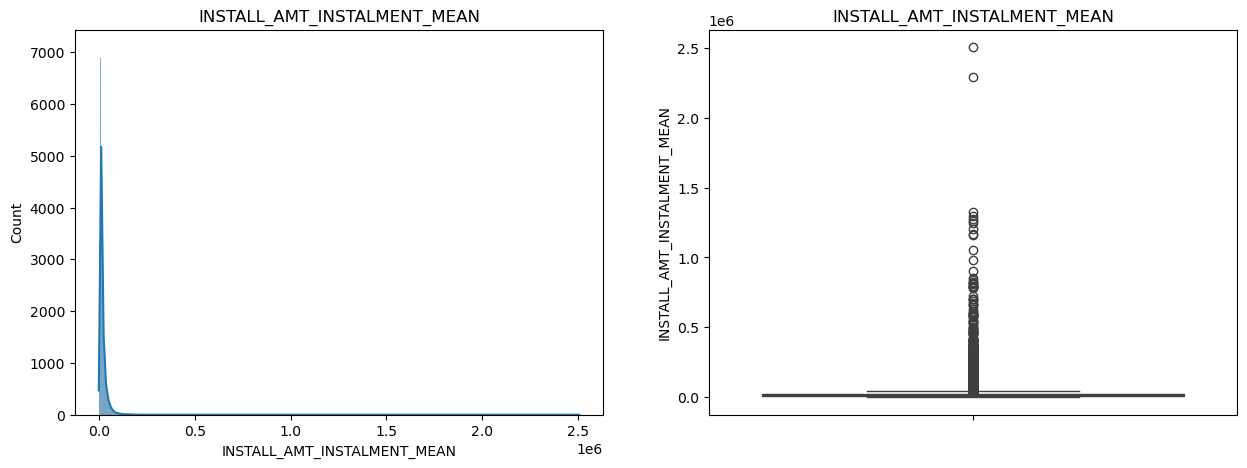

<Figure size 640x480 with 0 Axes>

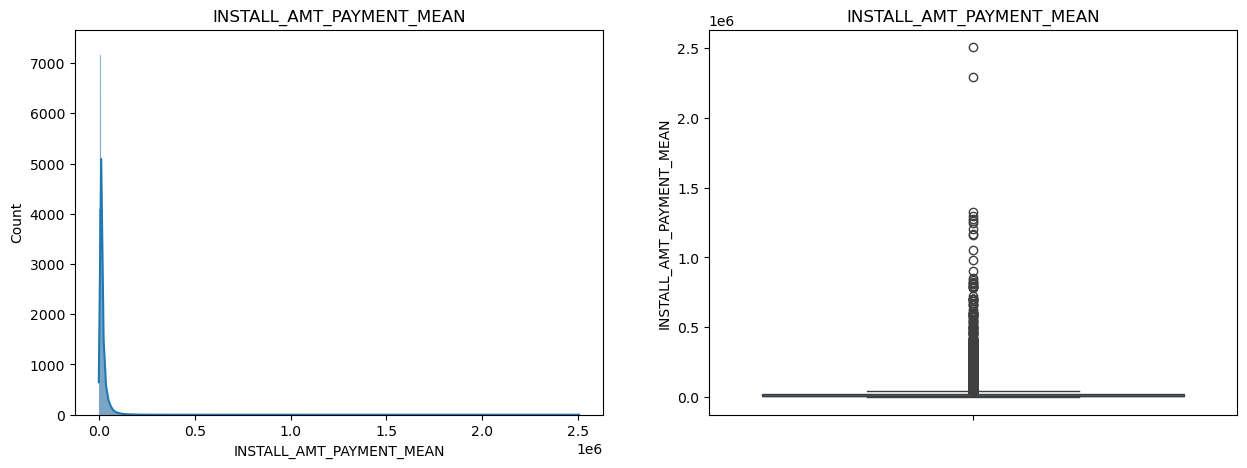

In [ ]:
# Hitogramme de visualisation de la distribution des variables continues
for col in train_data.select_dtypes('float').columns:
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(train_data[col], kde=True, ax=ax[0])
    ax[0].set_title(col)
    sns.boxplot(y=train_data[col], ax=ax[1])
    plt.title(col)
    plt.show()

A partir des graphes ci dessus nous pouvons noter que la distribution de la plus part de nos données ne sont pas symetrique et possedent des valeurs abérante. Aisnsi nous allons traiter ces dernieres dans suite à l'etape feature selection

## Selection des features

In [ ]:
#importation de librairie
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

Selection des feautures, Gestion et traitement des valeurs manques

In [ ]:
# Séparer les features (X) et la target (y)
X = train_data.drop(['TARGET', 'SK_ID_CURR'], axis=1)  # Variables explicatives
y = train_data['TARGET']  # Variable cible

In [ ]:
print('La taille des Variables pour l\'entraiment: ' , X.shape, y.shape)

La taille des Variables pour l'entraiment:  (307511, 104) (307511,)


In [ ]:
# Sélection automatique des colonnes numériques et catégorielles
numerical_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns


In [ ]:
numerical_features.shape,categorical_features.shape

((93,), (11,))

In [ ]:
# Suppression des variables inutiles
# Supprimer les colonnes quasi constantes (faible variance)
selector_var = VarianceThreshold(threshold=0.01)  # Supprime les colonnes quasi constantes
X_num_filtered = selector_var.fit_transform(X[numerical_features])
num_selected_features = numerical_features[selector_var.get_support()]

In [ ]:
num_selected_features.shape

(70,)

A travers ce code ci dessus, nous allons sélectionner les variables les plus pertinent avec un selecteur de variance avec un seuil de 0.01. Les variables ayant une variance inférieure à 0.01 seront considérées comme "quasi constantes" et donc inutiles.
Ainsi, avec la méthode get_support() nous allons  obtenir un masque booléen des features conservées
-  Ce masque est utilisé pour les  numerical_features pour garder uniquement les noms des colonnes qui ont passé le seuil de variance.
En définitive, num_selected_features.shape montre (70,), ce qui signifie :
- Sur les 93 variables numériques initiales
- Seules 70 ont une variance suffisante (>0.01)
- 23 variables ont été supprimées car quasi constantes


In [ ]:
#Supprimer les catégories dominantes (>99%) et haute cardinalité (>100 valeurs uniques)
low_variance_cat = [col for col in categorical_features if X[col].value_counts(normalize=True).max() > 0.99]
high_cardinality_cat = [col for col in categorical_features if X[col].nunique() > 100]
categorical_features = [col for col in categorical_features if col not in low_variance_cat + high_cardinality_cat]

In [ ]:
pd.Series(categorical_features).shape

(11,)

In [ ]:
#Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
#Encodage des données en train/test
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_cat_encoded = encoder.transform(X_test[categorical_features])

In [ ]:
#Imputation des variables categorielles
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat_encoded = cat_imputer.fit_transform(X_train_cat_encoded)
X_test_cat_encoded = cat_imputer.transform(X_test_cat_encoded)

In [ ]:
# Appliquer un imputeur pour traiter les valeurs manquantes dans les données encodées
chi2_selector = SelectKBest(score_func=chi2, k=15)  # Garde les 15 meilleures variables
X_train_cat_selected = chi2_selector.fit_transform(X_train_cat_encoded, y_train)
X_test_cat_selected = chi2_selector.transform(X_test_cat_encoded)

selected_cat_indices = chi2_selector.get_support(indices=True)
selected_cat_names = encoder.get_feature_names_out()[selected_cat_indices]

Cette etape nous prépare les variables catégorielles pour un modèle de machine learning en traitant les valeurs manquantes, en sélectionnant les caractéristiques les plus pertinentes et en conservant une trace des caractéristiques sélectionnées pour l'interprétation.



In [ ]:
X_train_cat_selected.shape, X_test_cat_selected.shape

((246008, 15), (61503, 15))

In [ ]:
# Sélection des meilleures variables numériques avec ANOVA (f_classif)
# Appliquer un imputeur pour les variables numériques
X_train_num_imputed = SimpleImputer(strategy='mean').fit_transform(X_train[num_selected_features])
num_imputer = SimpleImputer(strategy='mean')
X_train_num_imputed = num_imputer.fit_transform(X_train[num_selected_features])
X_test_num_imputed = num_imputer.transform(X_test[num_selected_features])
anova_selector = SelectKBest(score_func=f_classif, k=15)  # Garde les 15 meilleures variables
X_train_num_selected = anova_selector.fit_transform(X_train_num_imputed, y_train)
X_test_num_selected = anova_selector.transform(X_test_num_imputed)

selected_num_indices = anova_selector.get_support(indices=True)
selected_num_names = num_selected_features[selected_num_indices]

cette étape permet prépare les variables numériques pour un modèle de machine learning en traitant les valeurs manquantes, en sélectionnant les caractéristiques les plus pertinentes avec ANOVA, et en conservant une trace des variables sélectionnées pour l'interprétation.

In [ ]:
#  Concatenation des colonnes selectionnées
X_train_selected = np.hstack((X_train_num_selected, X_train_cat_selected))
X_test_selected = np.hstack((X_test_num_selected, X_test_cat_selected))

print(f"Variables numériques sélectionnées : {selected_num_names}")
print(f"Variables catégorielles sélectionnées : {selected_cat_names}")

Variables numériques sélectionnées : Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'PREV_DAYS_DECISION_MEAN',
       'PREV_DAYS_FIRST_DRAWING_MEAN', 'BUREAU_DAYS_CREDIT_MEAN',
       'BUREAU_DAYS_CREDIT_UPDATE_MEAN'],
      dtype='object')
Variables catégorielles sélectionnées : ['NAME_CONTRACT_TYPE_Revolving loans' 'CODE_GENDER_F' 'CODE_GENDER_M'
 'NAME_INCOME_TYPE_Pensioner' 'NAME_INCOME_TYPE_State servant'
 'NAME_INCOME_TYPE_Working' 'NAME_EDUCATION_TYPE_Higher education'
 'NAME_EDUCATION_TYPE_Secondary / secondary special'
 'NAME_FAMILY_STATUS_Civil marriage'
 'NAME_FAMILY_STATUS_Single / not married'
 'NAME_HOUSING_TYPE_With parents'
 'ORGANIZATION_TYPE_Business Entity Type 3'
 'ORGANIZATION_TYPE_Construction' 'ORGANIZATION_TYPE_Self-employed'
 'ORGANIZATION_TYPE_XNA']


In [ ]:
X_train_selected.shape,X_test_selected.shape

((246008, 30), (61503, 30))

**Gestion des valeurs aberrantes**

In [ ]:
#Gestion et suppression des valeurs aberantes pour la variable avec une distribution asymetrique

def replaceOutliersIQR(data):
    for col in data.select_dtypes('number').columns:
        if not (-0.5 <= data[col].skew() <= 0.5):
            Q1 = np.quantile(data[col], 0.25)
            Q3 = np.quantile(data[col], 0.75)
            IQR = Q3 - Q1
            limitInf = Q1 - 1.5*IQR
            limitSup = Q3 + 1.5*IQR

            data[col] = np.where(data[col] <= limitInf, limitInf, data[col])
            data[col] = np.where(data[col] >= limitSup, limitSup, data[col])
    return data


In [ ]:
# Convert X_train_selected back to DataFrame
X_train_selected_df = pd.DataFrame(X_train_selected, columns=list(selected_num_names) + list(selected_cat_names))

replaceOutliersIQR(data=X_train_selected_df)

DAYS_BIRTH  DAYS_EMPLOYED  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
0         -17775.0        -2503.0          -1321.0             1.0   
1         -12495.0         -429.0          -3590.0             1.0   
2         -11896.0         -875.0          -2879.0             1.0   
3         -14683.0        -2218.0          -4946.0             1.0   
4         -23119.0         3419.5          -4580.0             1.0   
...            ...            ...              ...             ...   
246003    -19030.0        -2219.0          -2540.0             1.0   
246004    -12054.0        -1848.0          -4025.0             1.0   
246005    -12242.0        -1489.0          -4376.0             1.0   
246006    -14825.0         3419.5          -4407.0             1.0   
246007    -16318.0        -2372.0          -4200.0             1.0   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                        2.0                          2.0   
1                        2.0                          2.0   
2                        2.0                          2.0   
3                        2.0                          2.0   
4                        2.0                          2.0   
...                      ...                          ...   
246003                   2.0                          2.0   
246004                   2.0                          2.0   
246005                   2.0                          2.0   
246006                   2.0                          2.0   
246007                   2.0                          2.0   

        REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  \
0                          0.0      0.683750      0.234015   
1                          0.0      0.587328      0.598926   
2                          0.0      0.271430      0.146442   
3                          0.0      0.684454      0.488455   
4                          0.0      0.192143      0.553165   
...                        ...           ...           ...   
246003                     0.0      0.108723      0.725276   
246004                     0.0      0.553644      0.728141   
246005                     0.0      0.706329      0.510443   
246006                     0.0      0.667817      0.556727   
246007                     0.0      0.452025      0.656158   

        DAYS_LAST_PHONE_CHANGE  ...  NAME_INCOME_TYPE_Working  \
0                      -1154.0  ...                       1.0   
1                      -1737.0  ...                       1.0   
2                       -584.0  ...                       1.0   
3                      -2152.0  ...                       0.0   
4                       -394.0  ...                       0.0   
...                        ...  ...                       ...   
246003                 -2452.0  ...                       0.0   
246004                 -1432.0  ...                       1.0   
246005                 -1094.0  ...                       1.0   
246006                     0.0  ...                       0.0   
246007                 -1838.0  ...                       1.0   

        NAME_EDUCATION_TYPE_Higher education  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
246003                                   0.0   
246004                                   0.0   
246005                                   0.0   
246006                                   0.0   
246007                                   0.0   

        NAME_EDUCATION_TYPE_Secondary / secondary special  \
0                                                     0.0   
1                                                     1.0   
2                                                     0.0   
3                                                     0.0   
4                         

In [ ]:
#Traitement des valeurs aberratntes sur une distribution normale avec la methode de Z-score
def remplacerOutliersZscore(data, threshold:int=3):
    for col in data.select_dtypes('number').columns:
        if -0.5 <= data[col].skew() <= 0.5:
            u = np.mean(data[col])
            sigma = np.std(data[col])
            median = np.median(data[col])
            z =  (data[col] - u)/sigma
            data[col] = np.where(abs(z) > threshold, median, data[col])
    return data

In [ ]:

remplacerOutliersZscore(data=X_train_selected_df)

DAYS_BIRTH  DAYS_EMPLOYED  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
0         -17775.0        -2503.0          -1321.0             1.0   
1         -12495.0         -429.0          -3590.0             1.0   
2         -11896.0         -875.0          -2879.0             1.0   
3         -14683.0        -2218.0          -4946.0             1.0   
4         -23119.0         3419.5          -4580.0             1.0   
...            ...            ...              ...             ...   
246003    -19030.0        -2219.0          -2540.0             1.0   
246004    -12054.0        -1848.0          -4025.0             1.0   
246005    -12242.0        -1489.0          -4376.0             1.0   
246006    -14825.0         3419.5          -4407.0             1.0   
246007    -16318.0        -2372.0          -4200.0             1.0   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                        2.0                          2.0   
1                        2.0                          2.0   
2                        2.0                          2.0   
3                        2.0                          2.0   
4                        2.0                          2.0   
...                      ...                          ...   
246003                   2.0                          2.0   
246004                   2.0                          2.0   
246005                   2.0                          2.0   
246006                   2.0                          2.0   
246007                   2.0                          2.0   

        REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  \
0                          0.0      0.683750      0.234015   
1                          0.0      0.587328      0.598926   
2                          0.0      0.271430      0.146442   
3                          0.0      0.684454      0.488455   
4                          0.0      0.192143      0.553165   
...                        ...           ...           ...   
246003                     0.0      0.108723      0.725276   
246004                     0.0      0.553644      0.728141   
246005                     0.0      0.706329      0.510443   
246006                     0.0      0.667817      0.556727   
246007                     0.0      0.452025      0.656158   

        DAYS_LAST_PHONE_CHANGE  ...  NAME_INCOME_TYPE_Working  \
0                      -1154.0  ...                       1.0   
1                      -1737.0  ...                       1.0   
2                       -584.0  ...                       1.0   
3                      -2152.0  ...                       0.0   
4                       -394.0  ...                       0.0   
...                        ...  ...                       ...   
246003                 -2452.0  ...                       0.0   
246004                 -1432.0  ...                       1.0   
246005                 -1094.0  ...                       1.0   
246006                     0.0  ...                       0.0   
246007                 -1838.0  ...                       1.0   

        NAME_EDUCATION_TYPE_Higher education  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
246003                                   0.0   
246004                                   0.0   
246005                                   0.0   
246006                                   0.0   
246007                                   0.0   

        NAME_EDUCATION_TYPE_Secondary / secondary special  \
0                                                     0.0   
1                                                     1.0   
2                                                     0.0   
3                                                     0.0   
4                         

Comme nos distributions sont asymetriques et possedent des valeurs aberantes, nous allons utiliser la methode IQR pour traiter les valeurs aberrantes en les remplaçants par la minimum ou le maximum du boxplot comme indiqué surl code ci-dessus

<Figure size 640x480 with 0 Axes>

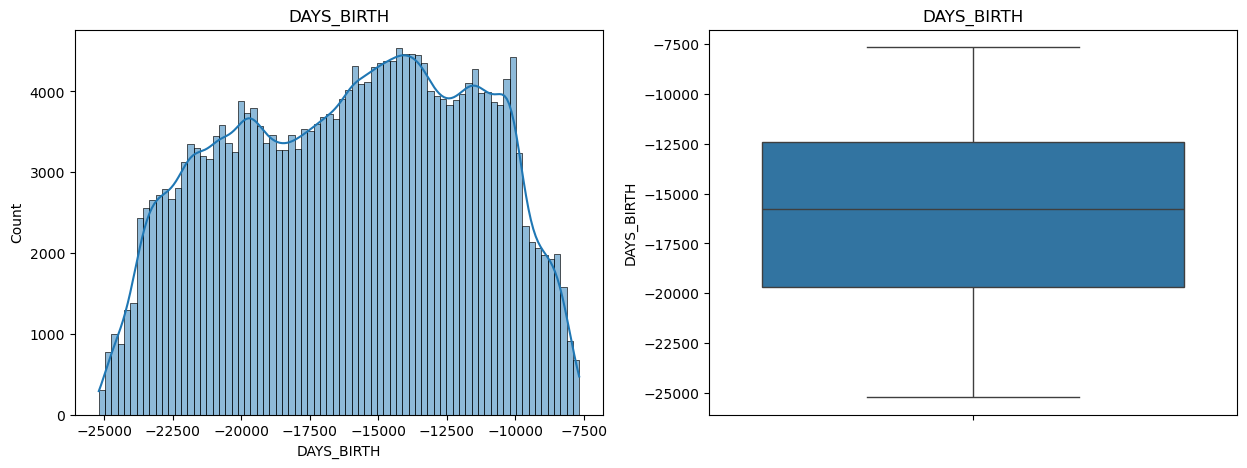

<Figure size 640x480 with 0 Axes>

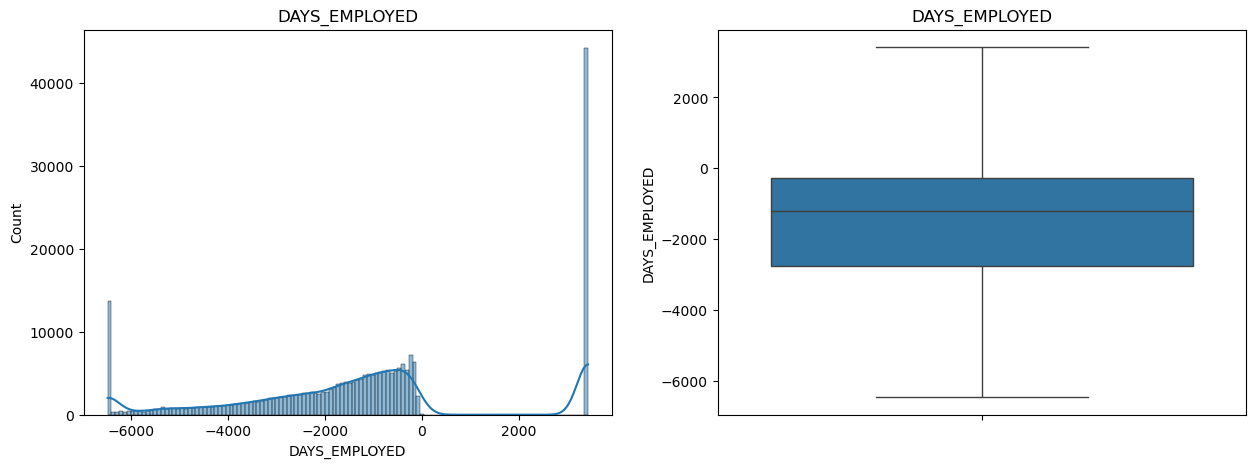

<Figure size 640x480 with 0 Axes>

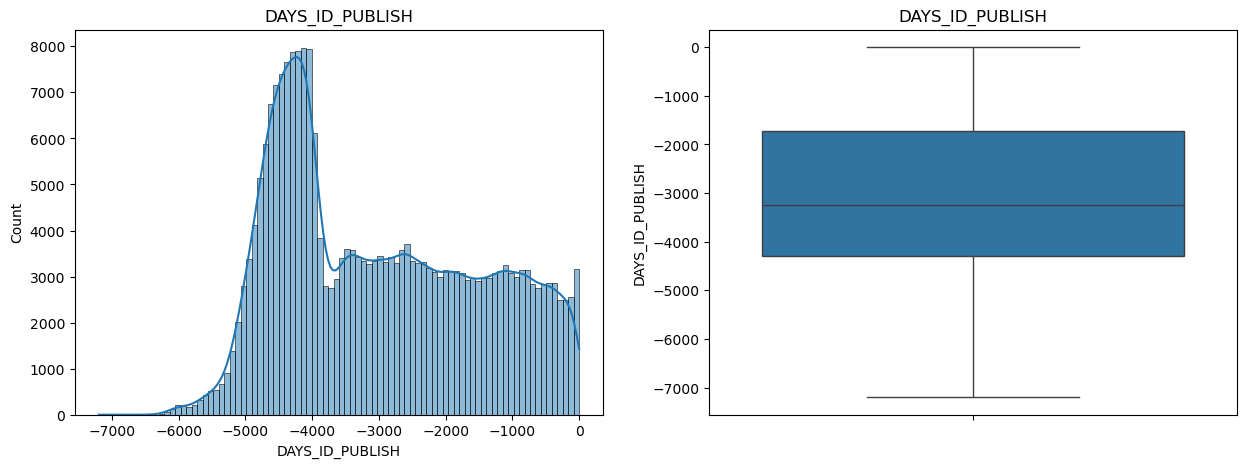

<Figure size 640x480 with 0 Axes>

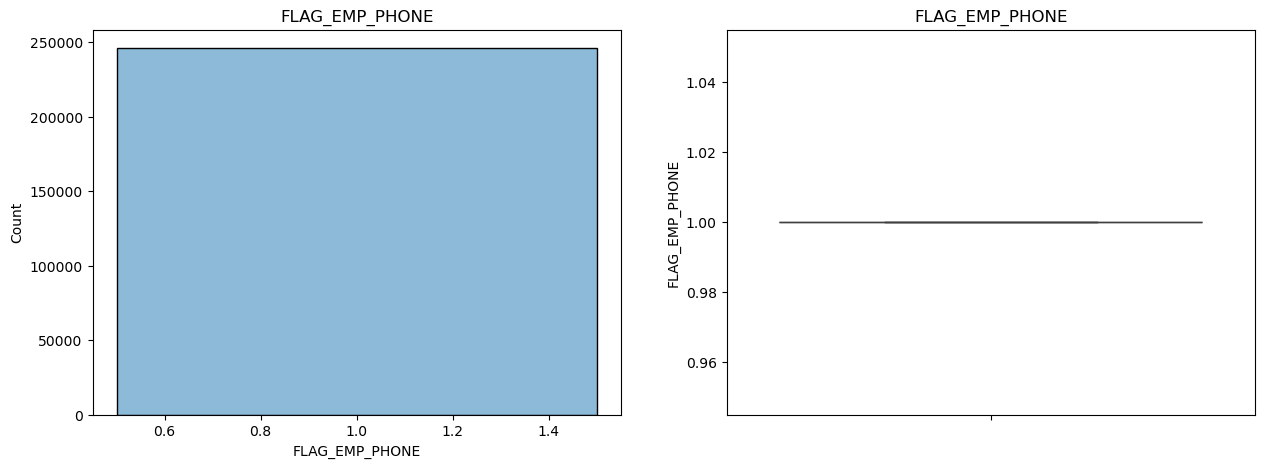

<Figure size 640x480 with 0 Axes>

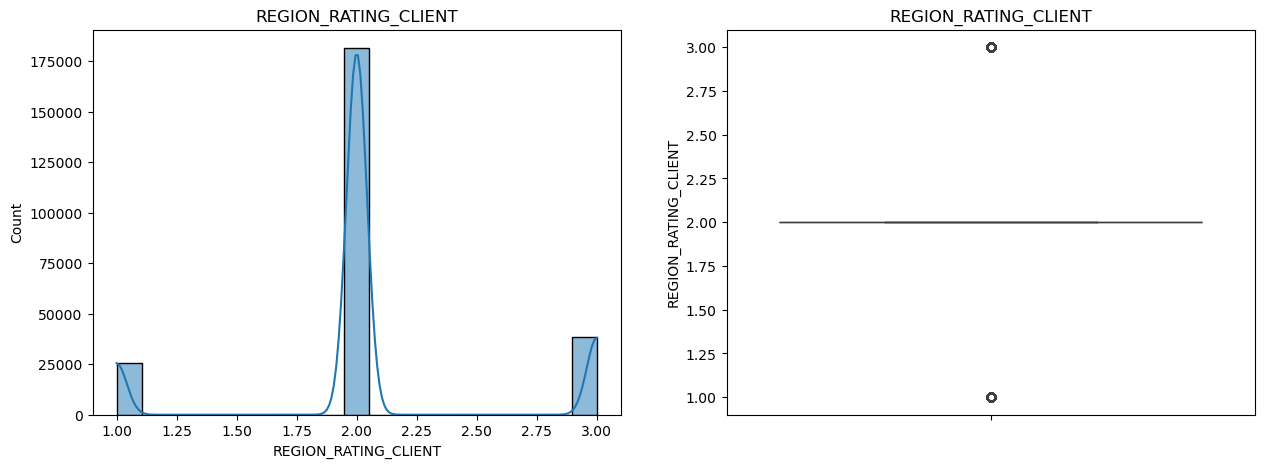

<Figure size 640x480 with 0 Axes>

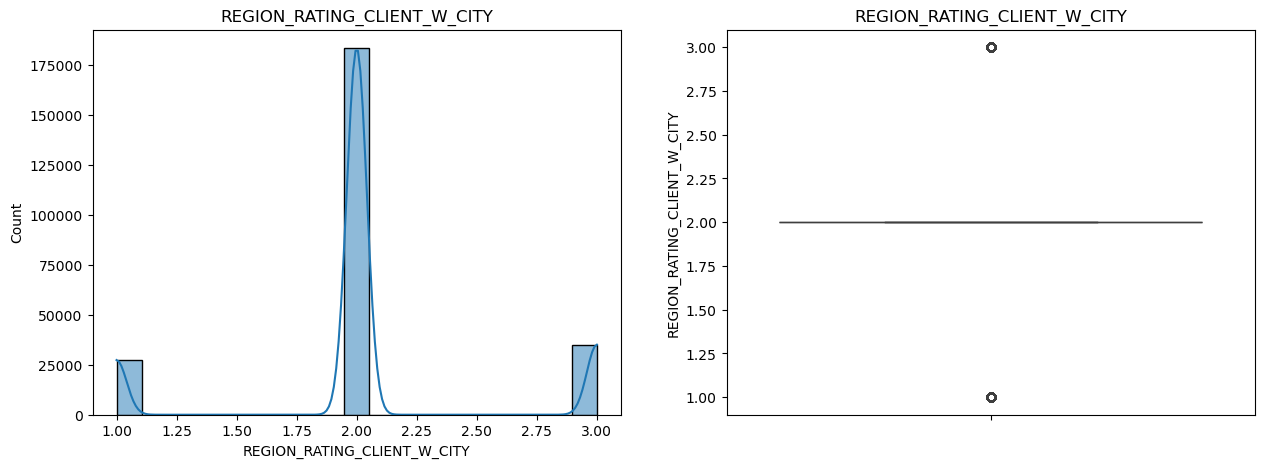

<Figure size 640x480 with 0 Axes>

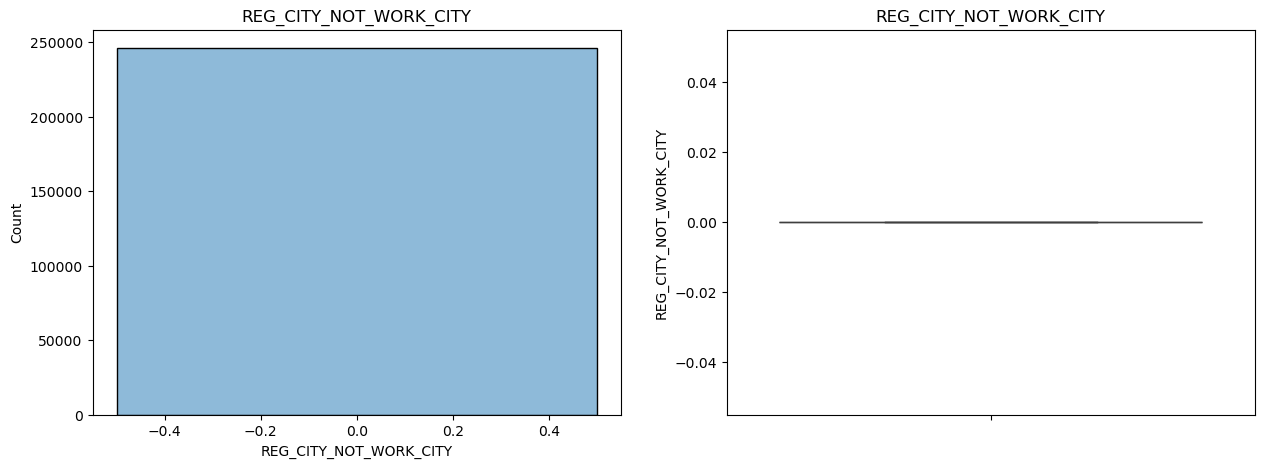

<Figure size 640x480 with 0 Axes>

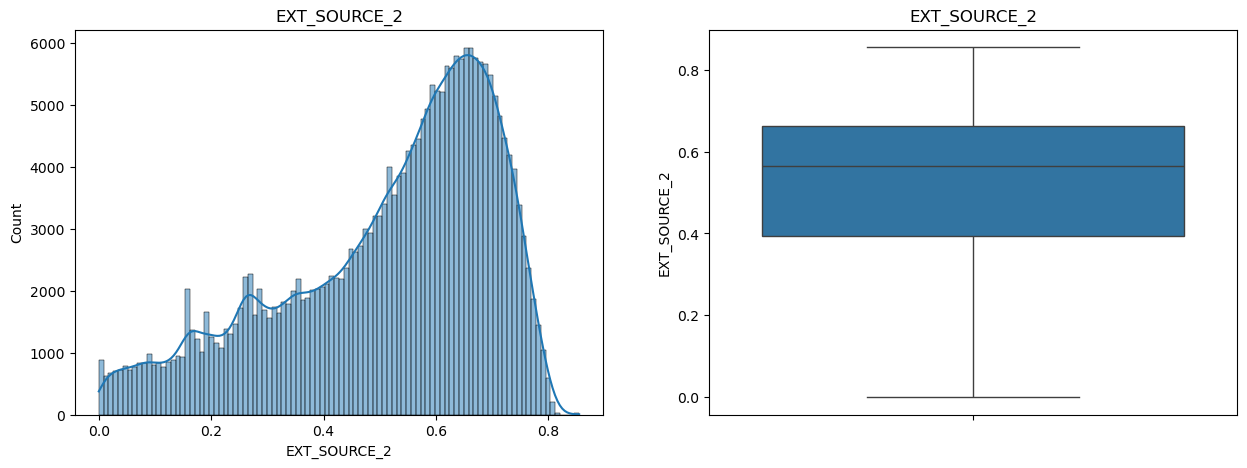

<Figure size 640x480 with 0 Axes>

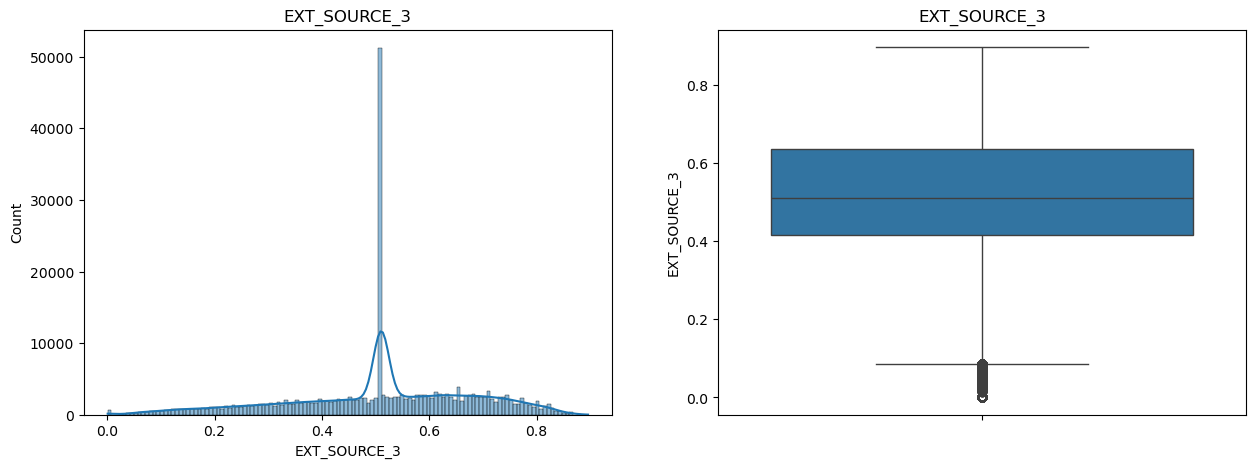

<Figure size 640x480 with 0 Axes>

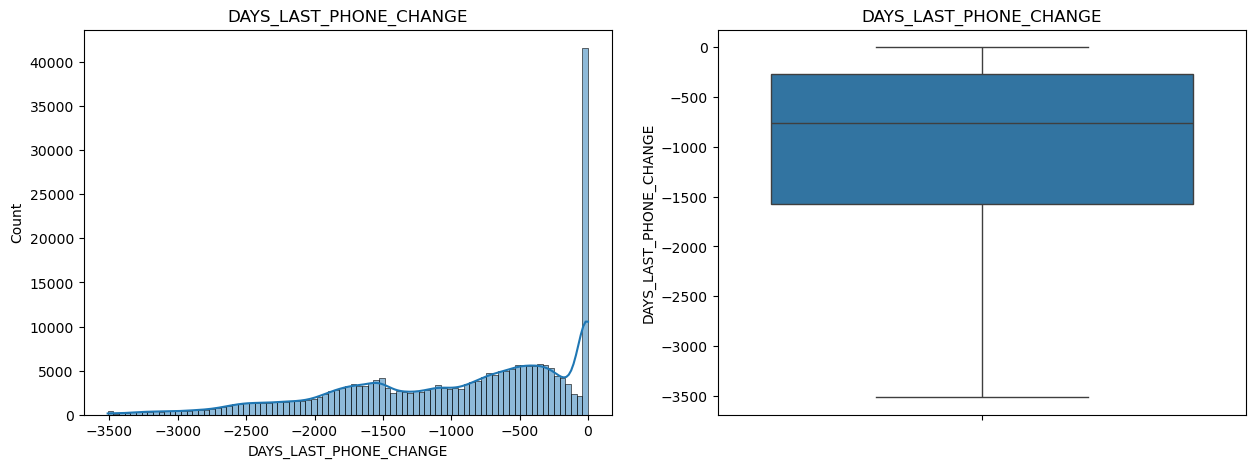

<Figure size 640x480 with 0 Axes>

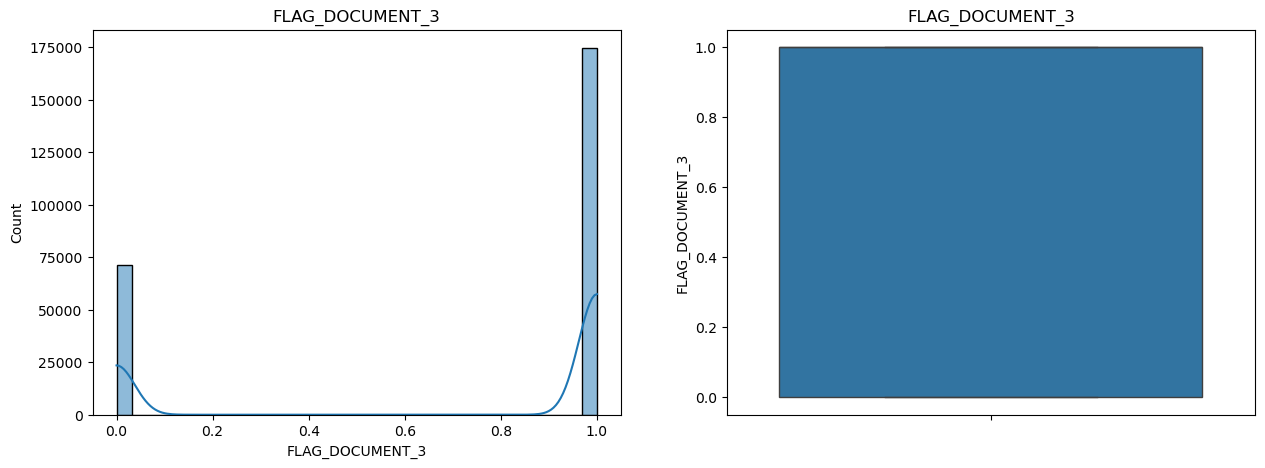

<Figure size 640x480 with 0 Axes>

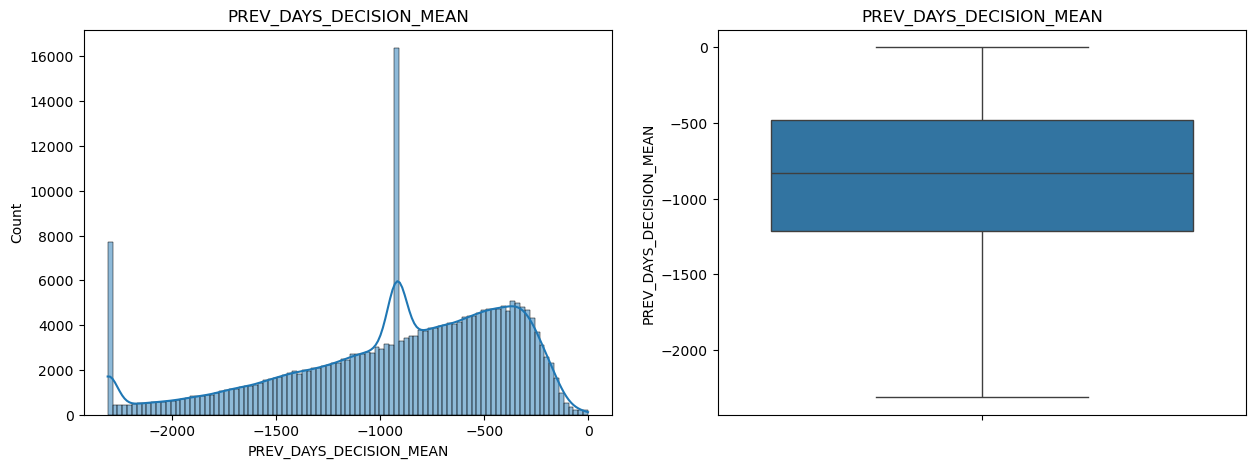

<Figure size 640x480 with 0 Axes>

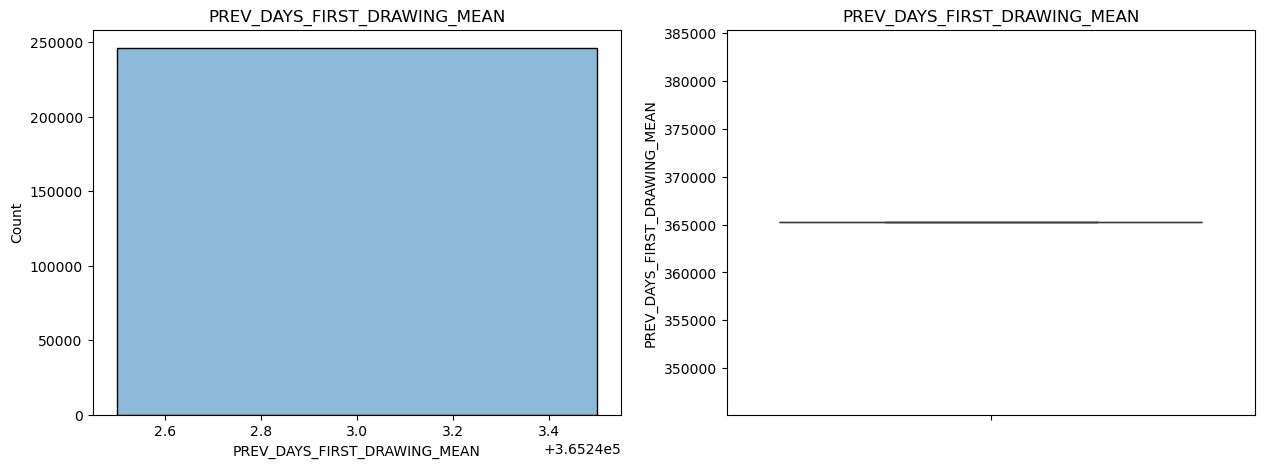

<Figure size 640x480 with 0 Axes>

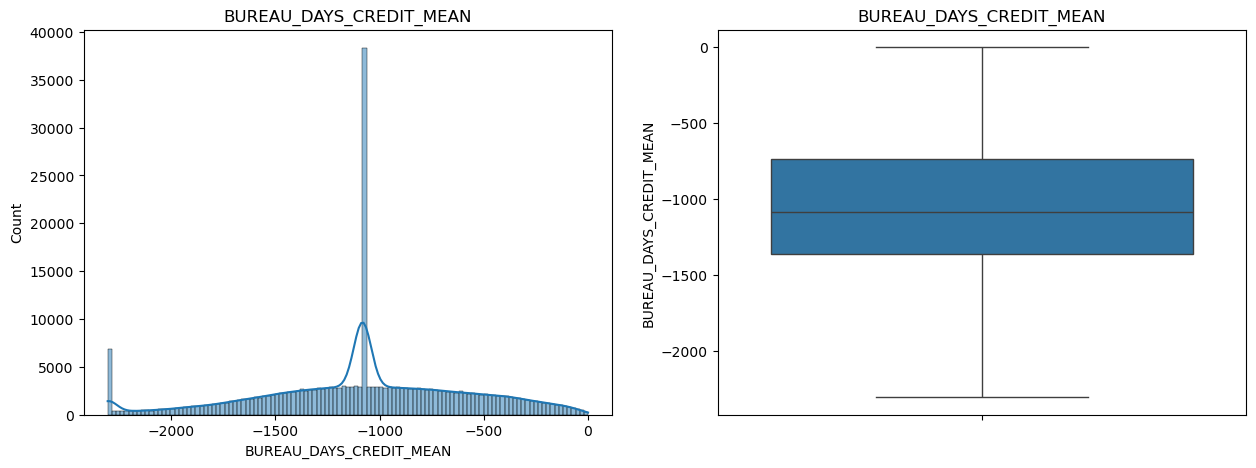

<Figure size 640x480 with 0 Axes>

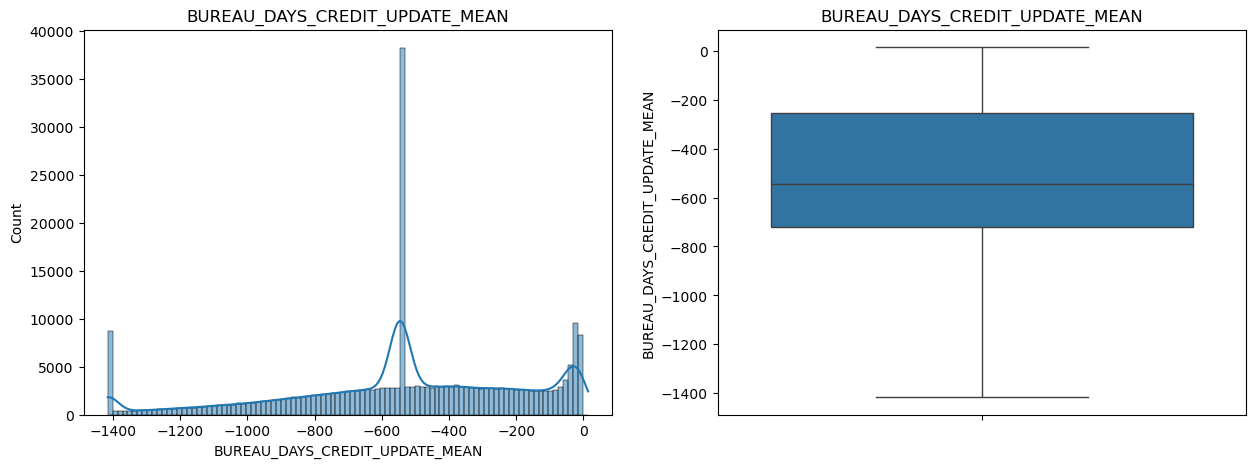

<Figure size 640x480 with 0 Axes>

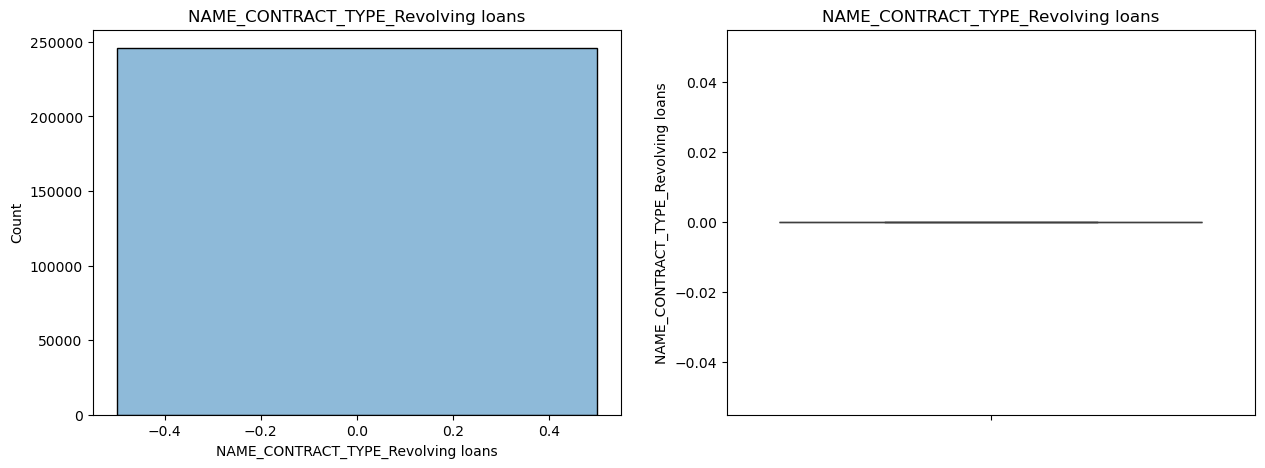

<Figure size 640x480 with 0 Axes>

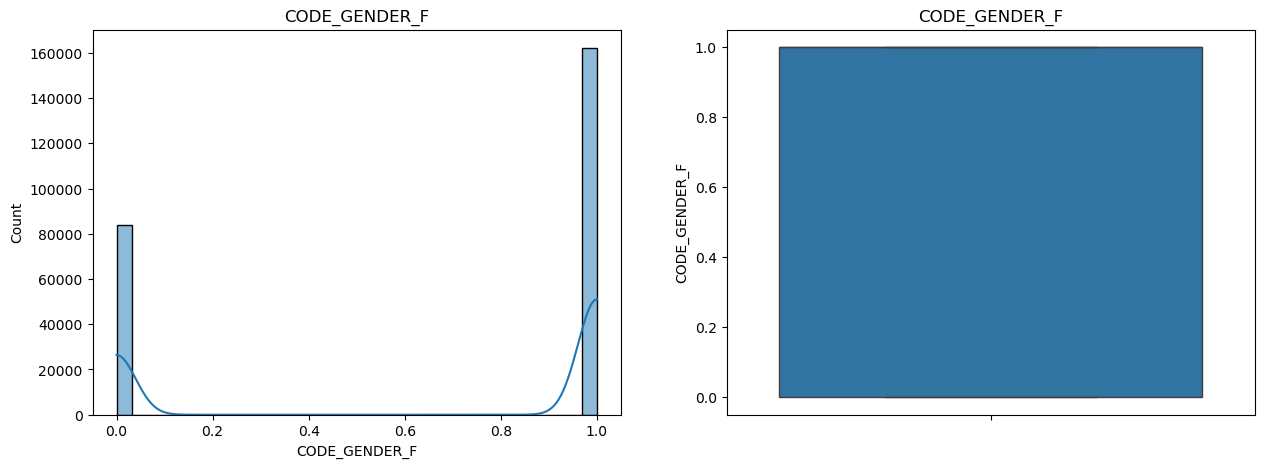

<Figure size 640x480 with 0 Axes>

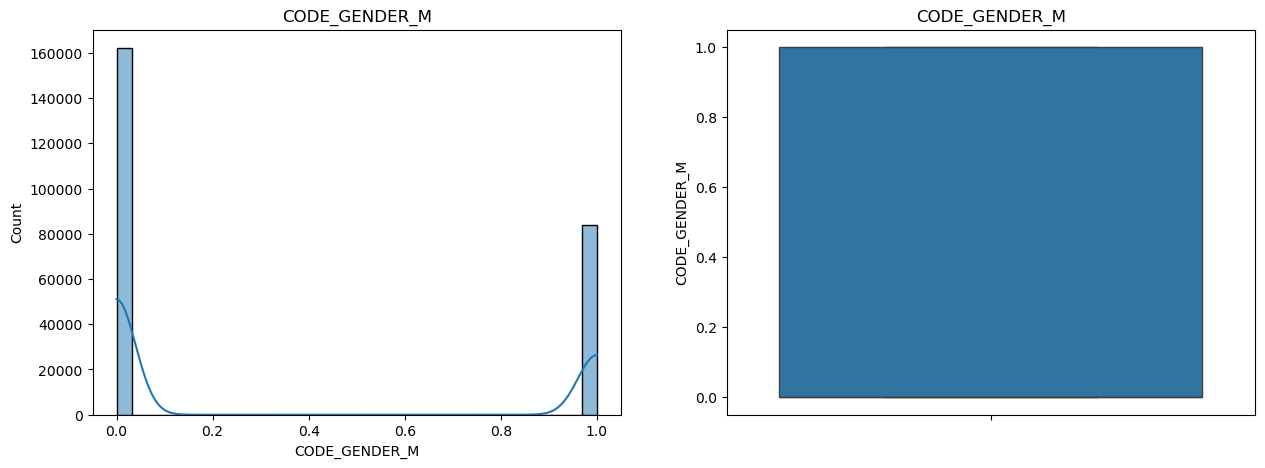

<Figure size 640x480 with 0 Axes>

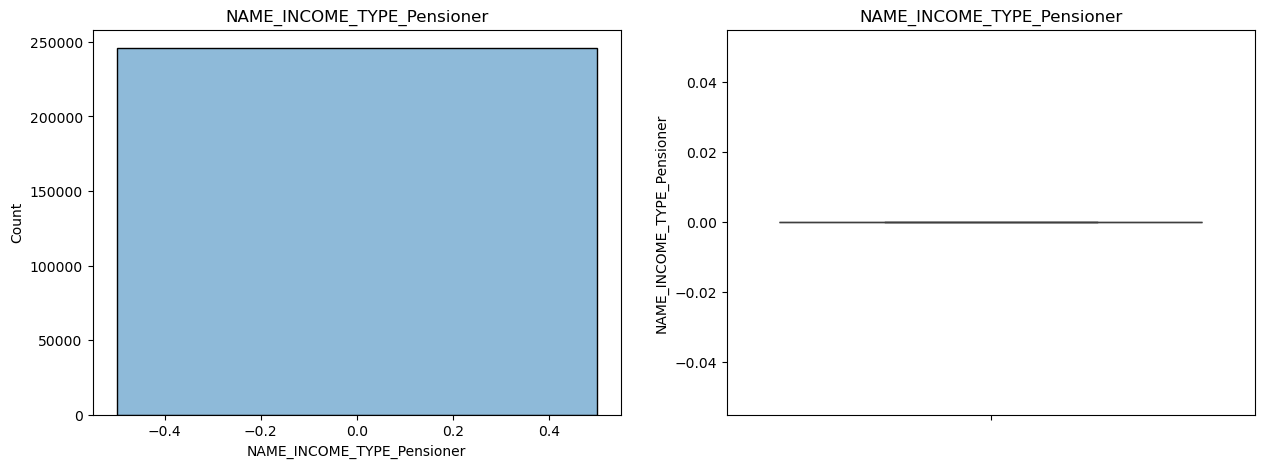

<Figure size 640x480 with 0 Axes>

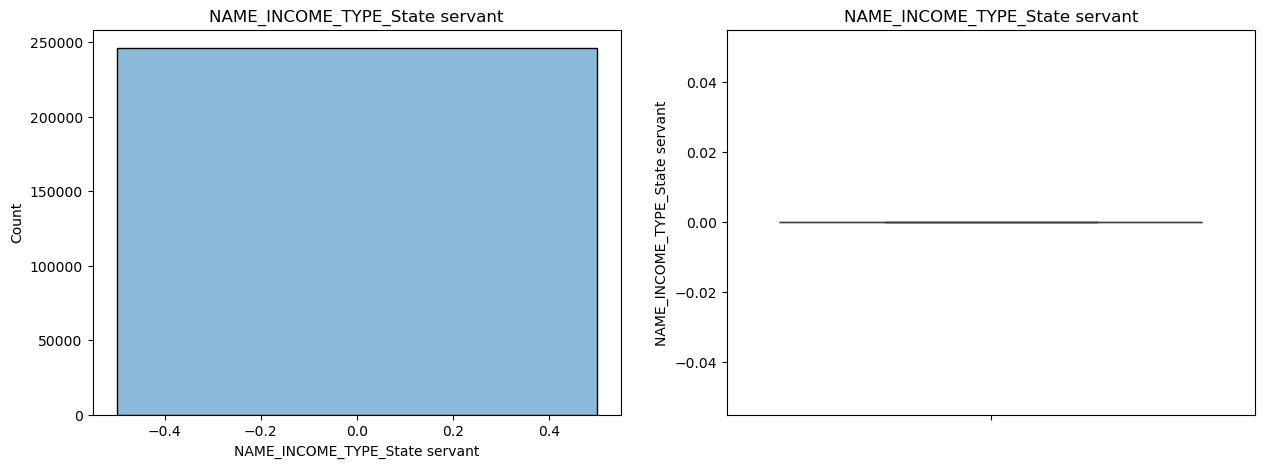

<Figure size 640x480 with 0 Axes>

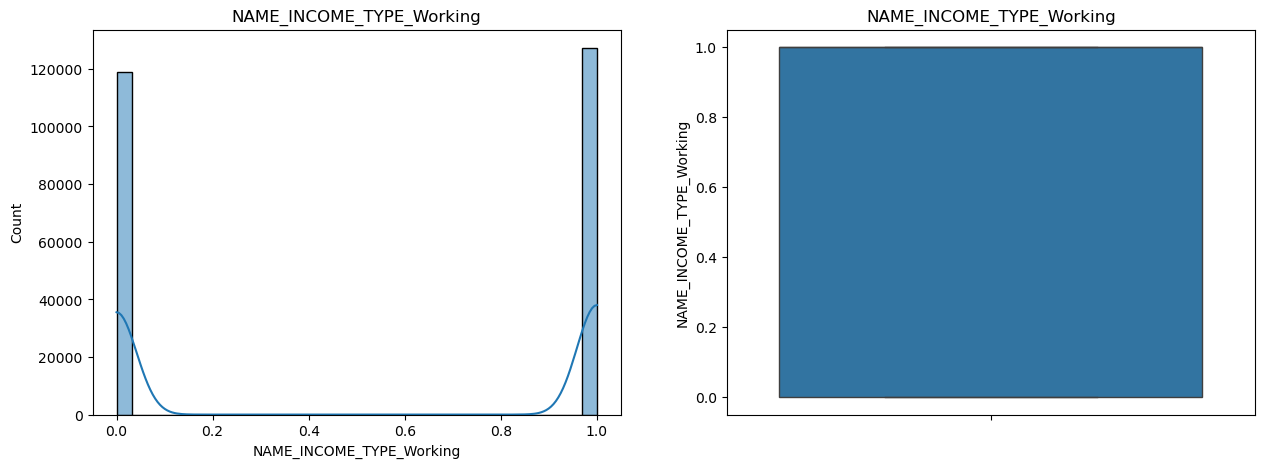

<Figure size 640x480 with 0 Axes>

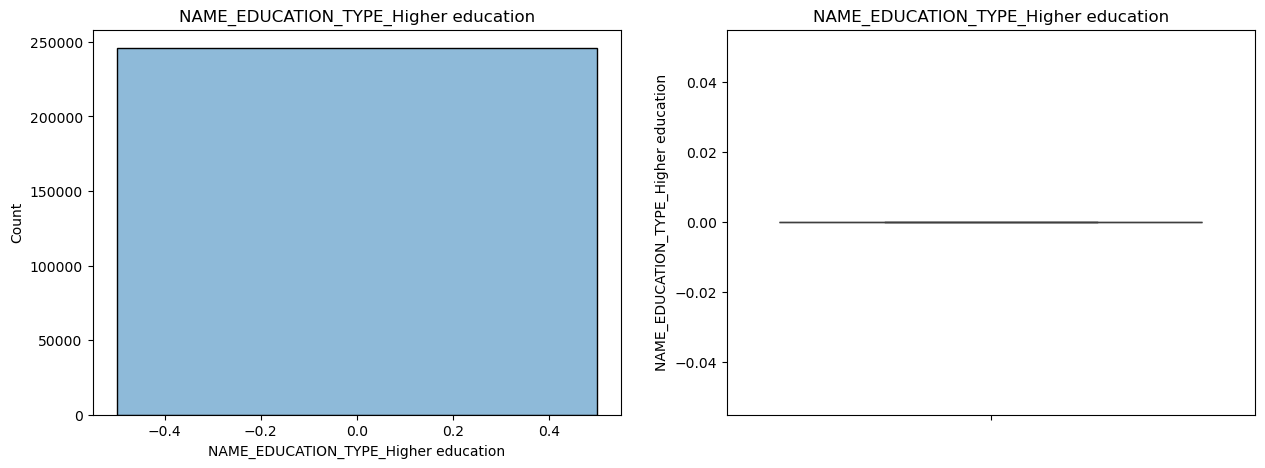

<Figure size 640x480 with 0 Axes>

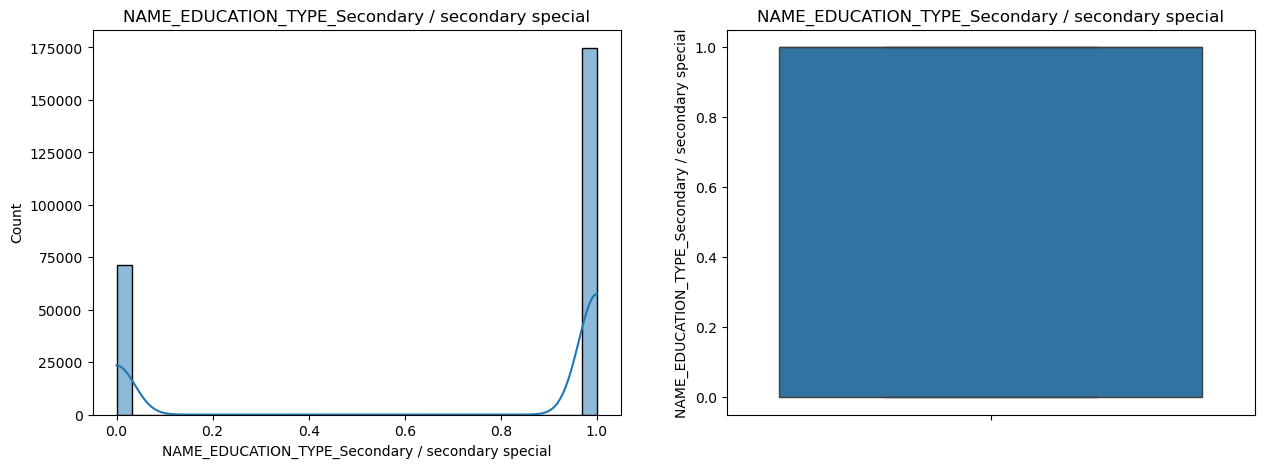

<Figure size 640x480 with 0 Axes>

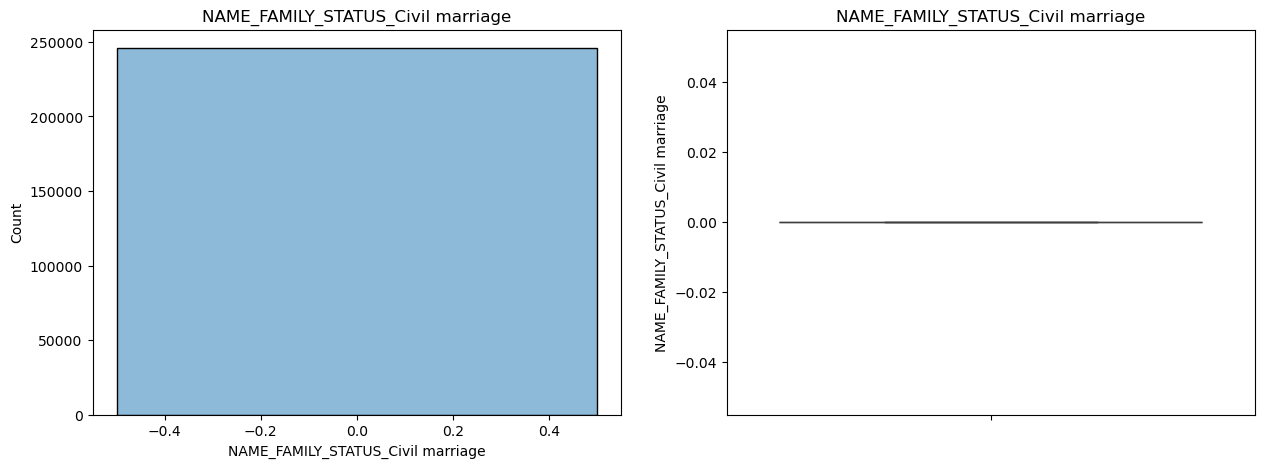

<Figure size 640x480 with 0 Axes>

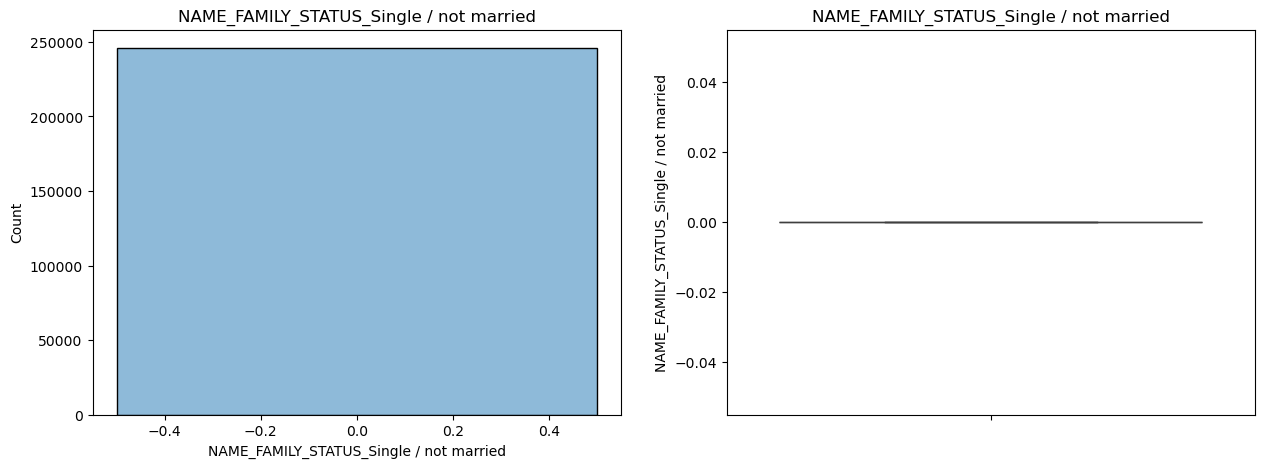

<Figure size 640x480 with 0 Axes>

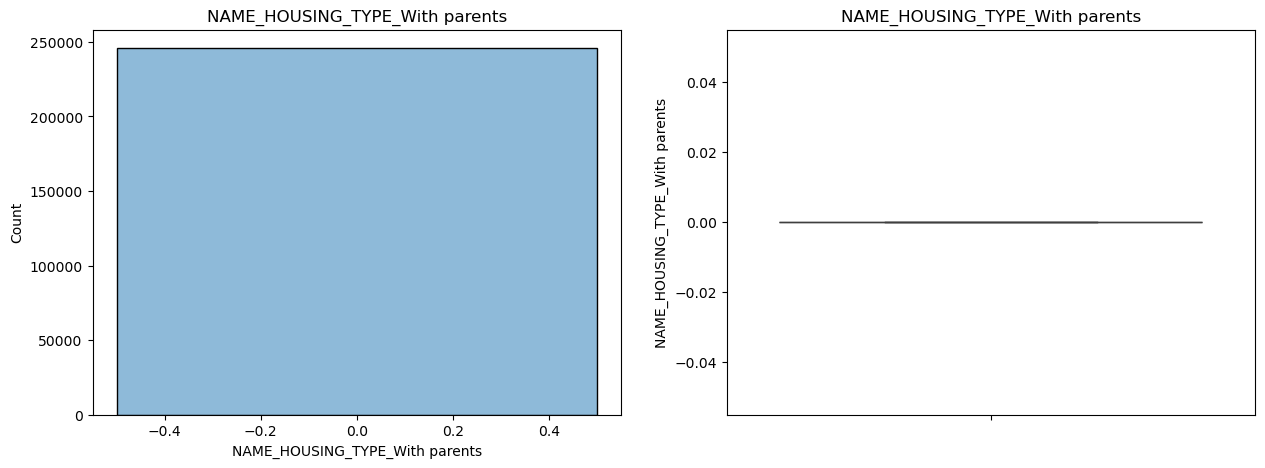

<Figure size 640x480 with 0 Axes>

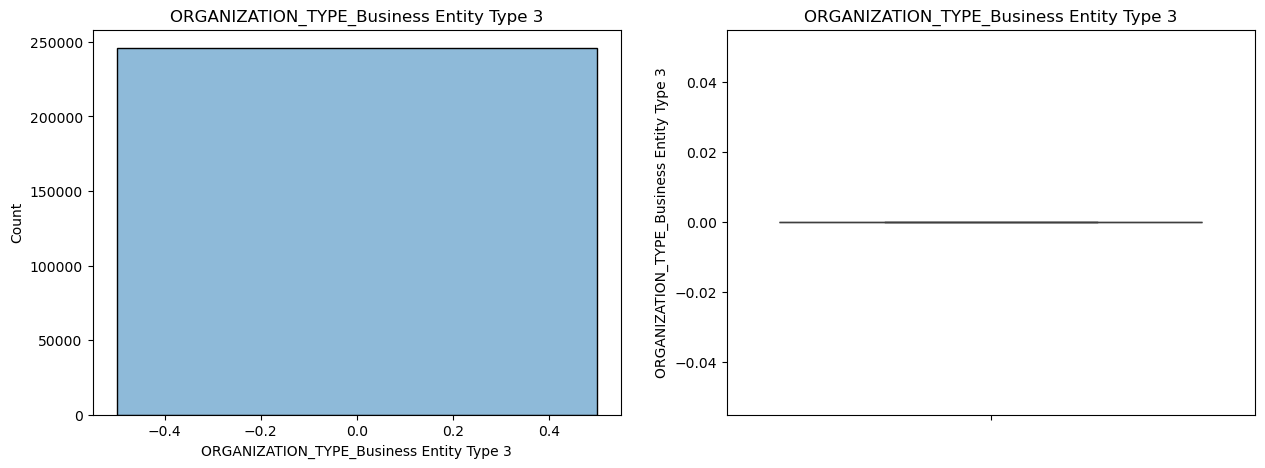

<Figure size 640x480 with 0 Axes>

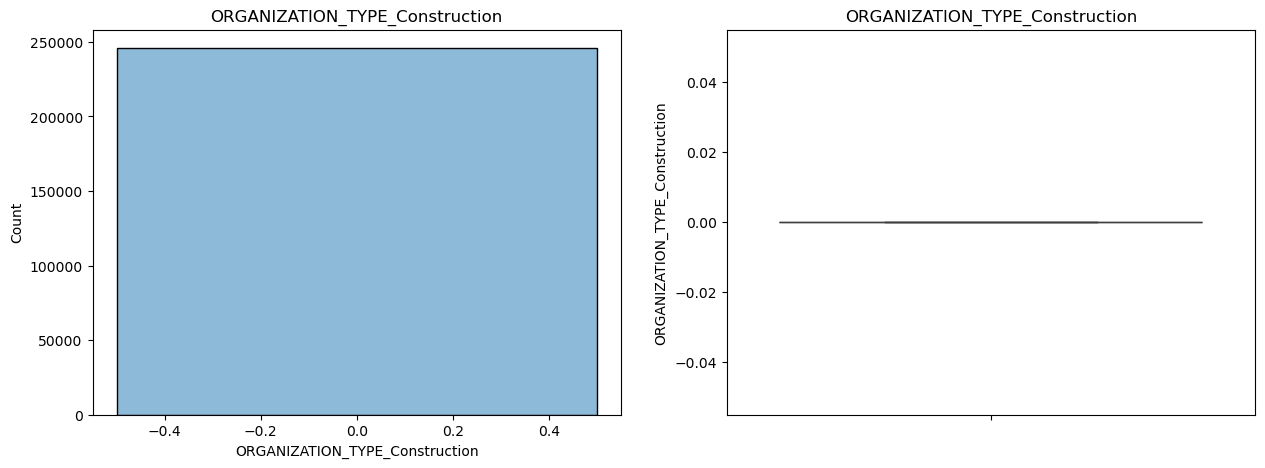

<Figure size 640x480 with 0 Axes>

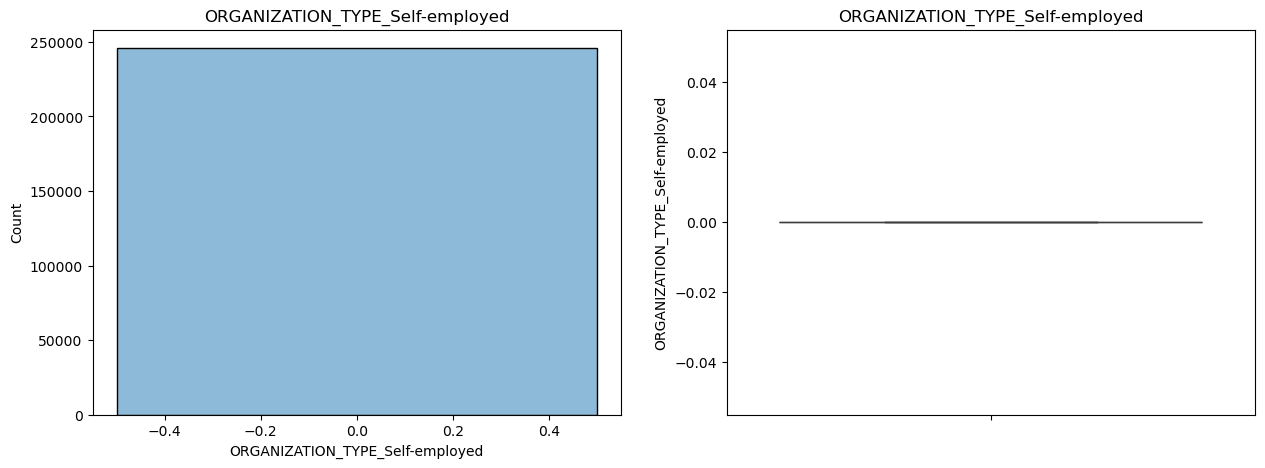

<Figure size 640x480 with 0 Axes>

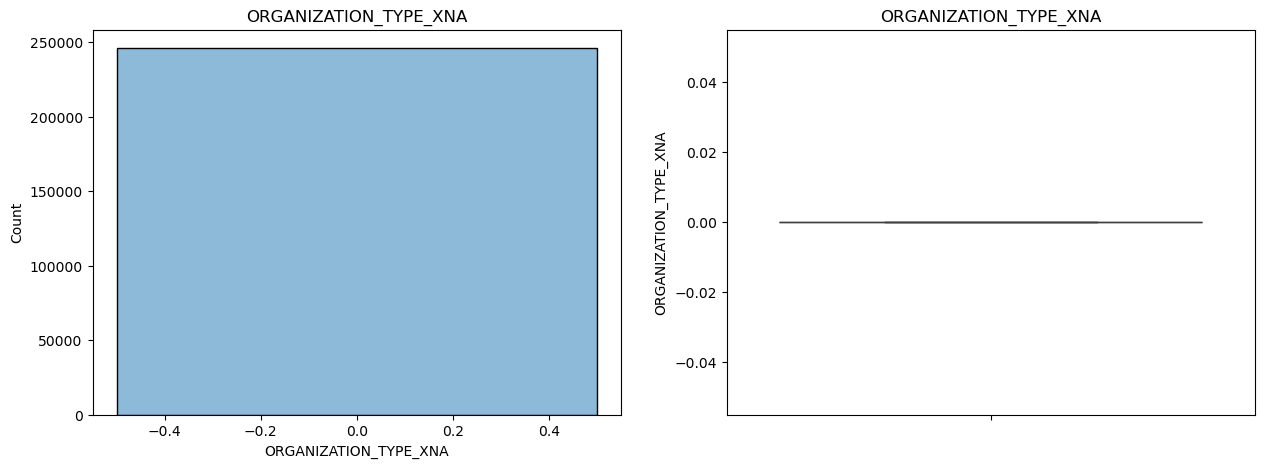

In [ ]:
#Affichage de la distribution et boxplot
for col in X_train_selected_df.columns:
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(X_train_selected_df[col], kde=True, ax=ax[0])
    ax[0].set_title(col)
    sns.boxplot(y=X_train_selected_df[col], ax=ax[1])
    plt.title(col)
    plt.show()

In [ ]:
y.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

On constate que le contenu de notre variation target, n'est pas equilibré donc faire un modele avec ces dernier ne sera pertinent. Nous allons dans le suite essayer de l'equilibrer afin de passer à l'entrainement des modele

NB : classe 0 : credit non remboursé;
     classe 1 : credit remboursé

In [ ]:
# Appliquer OverSample pour équilibrer les classes
# SMOTE doit être appliqué après l'encodage des variables catégorielles
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_selected, y_train)

In [ ]:
# Vérifier la distribution des classes après équilibrage
print("Distribution des classes après ros :")
print(pd.Series(y_train_resampled).value_counts())

Distribution des classes après ros :
TARGET
0    226148
1    226148
Name: count, dtype: int64


# Modelisation

-- models classsiques

In [ ]:
#Librairie
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score

In [ ]:
#Model KNN
# Initialisation du modèle KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Entraînement du modèle
knn_model.fit(X_train_resampled, y_train_resampled)

# Prédiction sur les données de test
y_pred_knn = knn_model.predict(X_test_selected)

# Évaluation du modèle

print(knn_model.score(X_test_selected, y_test))
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy du modèle KNN : {accuracy_knn:.4f}")
print(classification_report(y_test, y_pred_knn))


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
roc_auc_score(y_test, y_pred_knn)
# Matrice de confusion
confusion_matrix(y_test, y_pred_knn)


array([[56099,   439],
       [ 4903,    62]], dtype=int64)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialisation du modèle de Régression Logistique
logreg_model = LogisticRegression(random_state=0, max_iter=1000)

# Entraînement du modèle
logreg_model.fit(X_train_resampled, y_train_resampled)

# Prédiction sur les données de test
y_pred_logreg = logreg_model.predict(X_test_selected)

# Évaluation du modèle
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy du modèle de Régression Logistique : {accuracy_logreg:.4f}")
print(classification_report(y_test, y_pred_logreg))

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy du modèle de Régression Logistique : 0.6527
              precision    recall  f1-score   support

           0       0.96      0.65      0.78     56538
           1       0.14      0.65      0.23      4965

    accuracy                           0.65     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.65      0.73     61503



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialisation du modèle XGBoost
xgb_model = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

# Entraînement du modèle
xgb_model.fit(X_train_resampled, y_train_resampled)

# Prédiction sur les données de test
y_pred_xgb = xgb_model.predict(X_test_selected)

# Évaluation du modèle
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy du modèle XGBoost : {accuracy_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb))

c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy du modèle XGBoost : 0.9187
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.44      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



In [ ]:
#AUC
from sklearn.metrics import roc_auc_score, confusion_matrix

roc_auc_score(y_test, y_pred_xgb)

# Matrice de confusion
confusion_matrix(y_test, y_pred_xgb)

array([[56371,   167],
       [ 4835,   130]], dtype=int64)

In [ ]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialisation du modèle Random Forest
rf_model = RandomForestClassifier(random_state=0)

# Entraînement du modèle

rf_model.fit(X_train_resampled, y_train_resampled)

# Prédiction sur les données de test

y_pred_rf = rf_model.predict(X_test_selected)

# Évaluation du modèle

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print(classification_report(y_test, y_pred_rf))

Accuracy du modèle Random Forest : 0.9189
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.38      0.01      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.65      0.50      0.49     61503
weighted avg       0.88      0.92      0.88     61503



In [ ]:
#Comparaison des modeles classqique
print(f"Accuracy du modèle Random Forest : {accuracy_rf:.4f}")
print(classification_report(y_test, y_pred_rf))

print(f"Accuracy du modèle KNN : {accuracy_knn:.4f}")
print(classification_report(y_test, y_pred_knn))

print(f"Accuracy du modèle de Régression Logistique : {accuracy_logreg:.4f}")
print(classification_report(y_test, y_pred_logreg))

print(f"Accuracy du modèle XGBoost : {accuracy_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb))


Accuracy du modèle Random Forest : 0.9189
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.38      0.01      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.65      0.50      0.49     61503
weighted avg       0.88      0.92      0.88     61503

Accuracy du modèle KNN : 0.6857
              precision    recall  f1-score   support

           0       0.93      0.72      0.81     56538
           1       0.10      0.35      0.15      4965

    accuracy                           0.69     61503
   macro avg       0.51      0.53      0.48     61503
weighted avg       0.86      0.69      0.75     61503

Accuracy du modèle de Régression Logistique : 0.6527
              precision    recall  f1-score   support

           0       0.96      0.65      0.78     56538
           1       0.14      0.65      0.23      4965

    accuracy                           0.65     61503
 

# Analyse comparative des models classiques
*RandomForest*

---Le modèle est très performant pour prédire la classe 0 (majoritaire), mais il échoue presque complètement à identifier la classe 1 (minoritaire);

---L'accuracy élevée est peut etre trompeuse car elle est principalement due à la bonne prédiction de la classe majoritaire;

---Le modèle souffre d'un déséquilibre de classes (problème courant dans les ensembles de données déséquilibrés).

*KNN*

---Le modèle est meilleur que Random Forest pour identifier la classe 1 (rappel de 35 % contre 1 %), mais il reste médiocre;

---La précision pour la classe 1 est très faible (10 %), ce qui signifie que beaucoup de prédictions positives pour la classe 1 sont en réalité des faux positifs;

---L'accuracy est plus faible que Random Forest, mais le modèle est un peu plus équilibré.

*Regression Logistique*

---Le modèle est meilleur pour identifier la classe 1 (rappel de 65 %), mais la précision reste faible (14 %), ce qui signifie qu'il y a beaucoup de faux positifs;

---L'accuracy est plus faible que Random Forest et KNN, mais le modèle est plus équilibré pour la classe 1.

*XGBoost*

---Similaire à Random Forest, XGBoost est excellent pour prédire la classe 0 mais échoue presque complètement pour la classe 1;

---L'accuracy élevée est parfois trompeuse car elle est principalement due à la bonne prédiction de la classe majoritaire.


# Modeles optimisés

In [ ]:
#Modele XGBoost optimisé par GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
   'max_depth': [None, 5, 10],
    'learning_rate': [0.01, 0.1, 1],
    'gamma': [0, 0.1, 0.5],
    'reg_lambda': [0, 1, 10]
}

grid_search = GridSearchCV(XGBClassifier(random_state=0, use_label_encoder=False), param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_

best_params

# Création du modèle avec les meilleurs paramètres
best_xgb_model = XGBClassifier(random_state=0, use_label_encoder=False, **best_params)

# Prédiction sur les données de test
best_xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_best_xgb = best_xgb_model.predict(X_test_selected)

# Évaluation du modèle
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
print(f"Accuracy du meilleur modèle XGBoost : {accuracy_best_xgb:.4f}")
print(classification_report(y_test, y_pred_best_xgb))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   5.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   5.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:17:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   6.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   7.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   5.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  10.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  12.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  11.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  11.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  12.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   7.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=  19.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=  38.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   6.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   7.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   6.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   8.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=  31.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=  18.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   6.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   5.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   6.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   6.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=  12.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   6.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   7.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   8.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   7.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   8.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   7.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   5.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   7.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   7.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   6.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   6.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   6.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   7.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   7.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   7.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  13.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  14.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  14.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  15.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  13.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  12.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  10.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=  10.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=  11.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=  12.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=  11.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=  11.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   5.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   6.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   6.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   6.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   6.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   6.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   6.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   5.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   6.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   6.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   6.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   6.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time= 2.7min


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   6.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   6.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   7.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   7.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   7.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   6.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   8.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   8.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   9.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   9.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   8.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=  15.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=  10.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=  19.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   9.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   5.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   6.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   6.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   5.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   6.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  10.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  11.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  10.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  10.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  12.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   9.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   9.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=  10.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=  10.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=  21.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=  18.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=  14.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   8.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   6.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=  15.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   6.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   7.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  10.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time= 5.9min


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   8.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   6.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=  13.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   6.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   5.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   6.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   5.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   8.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   8.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   9.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   8.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   9.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   8.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   8.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   8.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   8.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.1, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   8.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=  13.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=  11.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=  32.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=0; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=1; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=0; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=1; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=0; total time=   5.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=1; total time=   6.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=100, reg_lambda=10; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=   9.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  12.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=  11.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time= 8.1min


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=0; total time=   7.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   6.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   7.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   6.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   6.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=1; total time=   6.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   6.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=13.1min


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   2.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   1.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   2.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   2.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   4.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   4.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   4.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   4.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   5.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=1; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=50, reg_lambda=10; total time=   1.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=0; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=100, reg_lambda=10; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=0; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=1; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   4.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=None, n_estimators=200, reg_lambda=10; total time=   3.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=0; total time=   1.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=1; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=50, reg_lambda=10; total time=   1.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=0; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=100, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=0; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=1; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=5, n_estimators=200, reg_lambda=10; total time=   3.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   1.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=1; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   1.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=50, reg_lambda=10; total time=   2.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   2.2s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   3.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=0; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   2.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=   4.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=  12.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=1; total time=  15.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=  17.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=  14.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   8.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=  23.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=100, reg_lambda=10; total time=   8.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  12.4s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  23.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=  12.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=0; total time=   9.7s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   7.3s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.5s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  11.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=  10.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=1; total time=   5.9s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   4.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   7.0s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   7.1s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   6.6s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.5, learning_rate=1, max_depth=10, n_estimators=200, reg_lambda=10; total time=   6.8s


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy du meilleur modèle XGBoost : 0.9186
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.43      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



In [ ]:
# Évaluation du modèle
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
print(f"Accuracy du meilleur modèle XGBoost : {accuracy_best_xgb:.4f}")
print(classification_report(y_test, y_pred_best_xgb))

Accuracy du meilleur modèle XGBoost : 0.9186
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.43      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



In [ ]:
#AUC
roc_auc_score(y_test, y_pred_best_xgb)

# Matrice de confusion
confusion_matrix(y_test, y_pred_best_xgb)

array([[56365,   173],
       [ 4832,   133]], dtype=int64)

In [ ]:
#Modele Regression Logistique optimisé par GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_

best_params

# Création du modèle avec les meilleurs paramètres
best_logreg_model = LogisticRegression(random_state=0, **best_params)

# Prédiction sur les données de test
best_logreg_model.fit(X_train_resampled, y_train_resampled)
y_pred_best_logreg = best_logreg_model.predict(X_test_selected)

# Évaluation du modèle
accuracy_best_logreg = accuracy_score(y_test, y_pred_best_logreg)

print(f"Accuracy du meilleur modèle Régression Logistique : {accuracy_best_logreg:.4f}")
print(classification_report(y_test, y_pred_best_logreg))


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy du meilleur modèle Régression Logistique : 0.6873
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503



c:\Users\USER\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
#AUC
roc_auc_score(y_test, y_pred_best_logreg)

# Matrice de confusion
confusion_matrix(y_test, y_pred_best_logreg)

array([[38942, 17596],
       [ 1635,  3330]], dtype=int64)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


In [ ]:
#RandomForet avec RandomizedSearchCV
preprocessor = ColumnTransformer(
    transformers=[
        ('num', KNNImputer(), var_num),  # Imputation des variables numériques
        ('cat', OneHotEncoder(handle_unknown='ignore'), var_cat)  # Encodage des variables catégorielles
    ])

# Pipeline complet
model = make_pipeline(
    preprocessor,  # Appliquer le préprocessing
    SelectKBest(score_func=f_classif, k=10),  # Sélection des 10 meilleures variables
    PolynomialFeatures(degree=2),  # Features polynomiales de degré 2
    PCA(n_components=10),  # Réduction de dimension avec PCA
    RandomForestClassifier(random_state=42)  # Classificateur RandomForest
)

# Paramètres à tester pour RandomizedSearchCV
params = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 5, 10],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

# RandomizedSearchCV : Recherche aléatoire sur les hyperparamètres
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=5, random_state=42, n_jobs=-1 )

# Apprentissage avec RandomizedSearchCV sur les données équilibrées
random_search.fit(X_resampled, y_resampled)

# Affichage des meilleurs paramètres trouvés avec RandomizedSearchCV
print("Meilleurs paramètres (RandomizedSearchCV) :")
print(random_search.best_params_)

# Évaluation du modèle sur l'ensemble de test avec RandomizedSearchCV
score_random = random_search.score(X_test_transformed, y_test)
print(f"\nScore sur l'ensemble de test avec RandomizedSearchCV: {score_random:.4f}")

Meilleurs paramètres (RandomizedSearchCV) :
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': None}

Score sur l'ensemble de test avec RandomizedSearchCV: 0.8756
